# Subspace Digital Twin, Parameter Selection Under Uncertainty

*BlockScience, April 2024*

Here we execute the PSUU framework for the subspace economic model. 

For more information see the methodology document by Danilo: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view

## Part 1. Architecture Overview

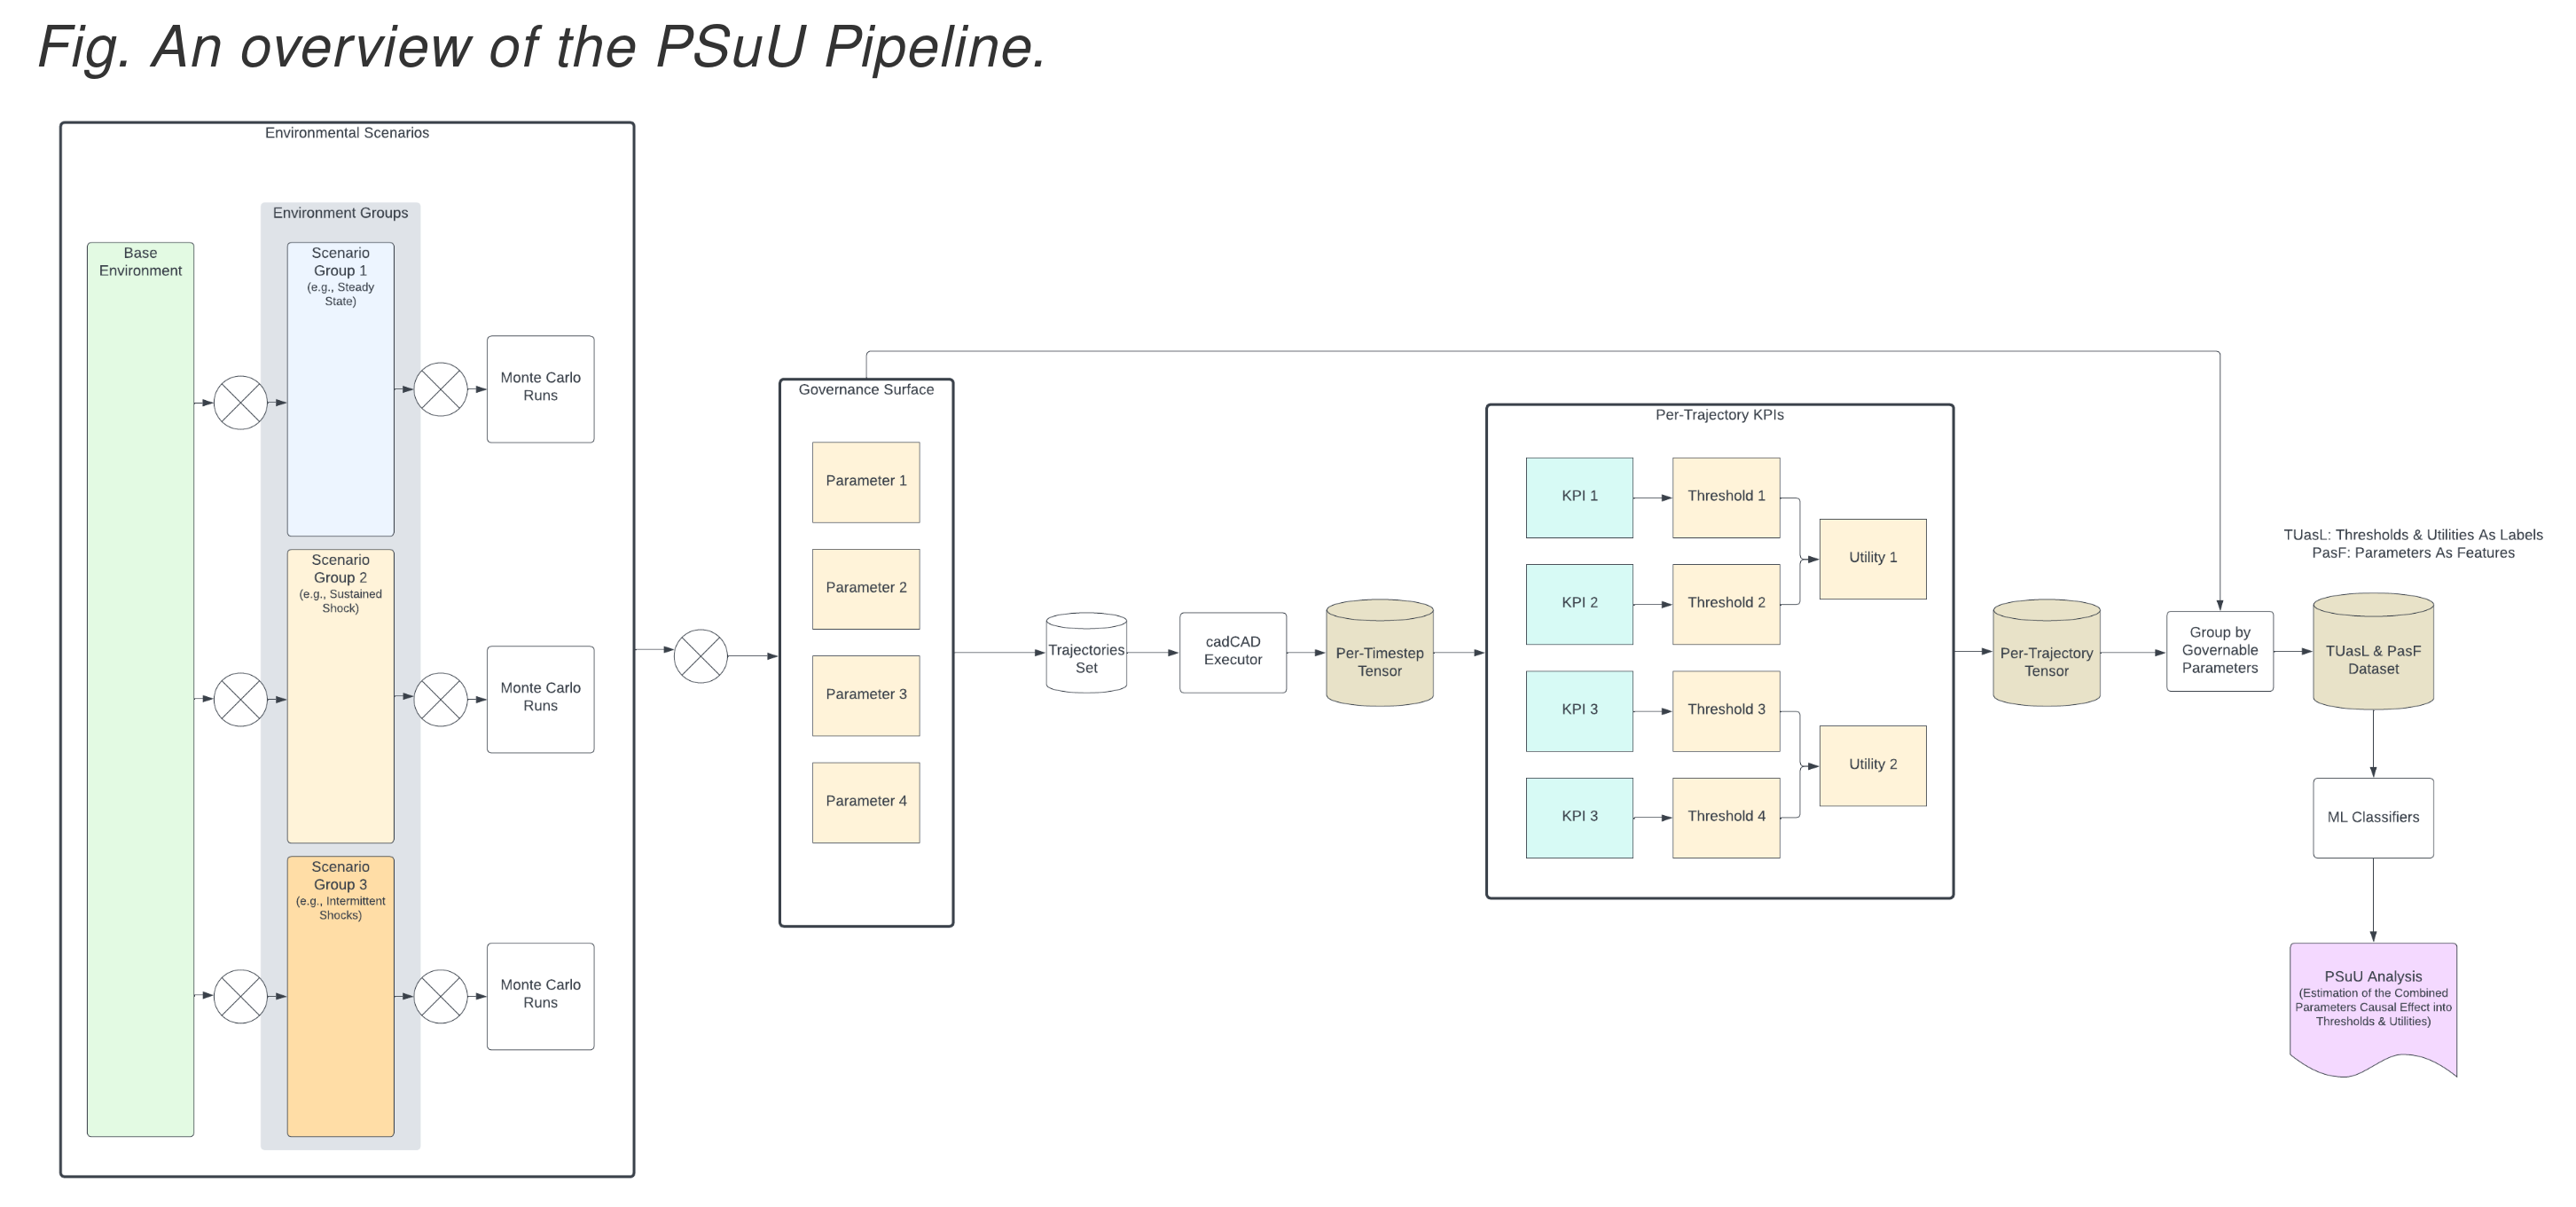

## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import hvplot.pandas
import holoviews as hv
from typing import Callable, Dict, List, Tuple, Union

from subspace_model.psuu.plots import create_decision_tree_importances_plot
from subspace_model.psuu import timestep_tensor_to_trajectory_tensor, GOVERNANCE_SURFACE_PARAMS
from subspace_model.psuu.kpis import KPI_functions, calculate_goal_score, GOAL_KPI_GROUPS

In [2]:
pd.set_option('display.max_columns', None)

latest = sorted(glob("../../data/simulations/psuu-2024*"))[-1]

sim_df = pd.read_pickle(latest, compression='gzip')

N_sweeps = len(sim_df.subset.unique())
N_runs = len(sim_df.run.unique())
N_trajectories = N_sweeps * N_runs
N_timesteps = len(sim_df.timestep.unique())
N_measurements = N_trajectories * N_timesteps

print(f"Tensor Size: {N_measurements=:,} over {N_trajectories=:,} | ({N_sweeps=:,}, {N_runs=:,}, {N_timesteps=:,})\t")

Tensor Size: N_measurements=2,194,000 over N_trajectories=2,000 | (N_sweeps=100, N_runs=20, N_timesteps=1,097)	


In [3]:
sim_df.days_passed.max()

1096.0

Aggregating trajectories.

In [4]:
agg_df = timestep_tensor_to_trajectory_tensor(sim_df).reset_index()
agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['subset', 'run']).describe()

simulation  mean_relative_community_owned_supply  \
count       100.0                            100.000000   
mean          0.0                              0.744001   
std           0.0                              0.006043   
min           0.0                              0.732487   
25%           0.0                              0.739808   
50%           0.0                              0.744941   
75%           0.0                              0.746188   
max           0.0                              0.756448   

       mean_farmer_subsidy_factor  \
count                  100.000000   
mean                     0.998299   
std                      0.002000   
min                      0.988322   
25%                      0.997986   
50%                      0.998960   
75%                      0.999382   
max                      0.999711   

       mean_proposing_rewards_per_newly_pledged_space  \
count                                    1.000000e+02   
mean                                     5.843323e-13   
std                                      2.761468e-13   
min                                      8.979287e-14   
25%                                      3.845281e-13   
50%                                      5.631682e-13   
75%                                      7.952636e-13   
max                                      1.454237e-12   

       mean_proposer_reward_minus_voter_reward  cumm_rewards_before_1yr  \
count                               100.000000             1.000000e+02   
mean                              29967.140341             4.140318e+07   
std                               19877.391877             1.716415e+07   
min                                3198.436870             7.912156e+06   
25%                               13286.220701             2.634117e+07   
50%                               21897.169941             4.207594e+07   
75%                               44157.989324             5.527421e+07   
max                               80619.817536             7.378042e+07   

       abs_sum_storage_fees_per_sum_compute_fees  cumm_rewards  
count                                 100.000000  1.000000e+02  
mean                                43924.409327  1.049798e+08  
std                                 27963.591936  5.050867e+07  
min                                 12278.007015  1.846676e+07  
25%                                 21739.838401  7.370472e+07  
50%                                 29257.751840  1.131863e+08  
75%                                 74706.228143  1.264273e+08  
max                                 96040.733179  2.215443e+08

Kernal density estimate plots of KPI outcomes over trajectories.

Evaluating the utility tensor.

In [5]:


# Type alias for a Criterion function
Criterion = Callable[[float, pd.Series], bool]

def evaluate(x: pd.Series, data: pd.DataFrame, success_criteria: Union[str, Criterion]) -> pd.Series:
    col_name = x.name  # Assuming col_name comes from the Series name
    if isinstance(success_criteria, str):
        if success_criteria == 'smaller_than_median':
            y = data.loc[:, col_name] < data.loc[:, col_name].median()
        elif success_criteria == 'larger_than_median':
            y = data.loc[:, col_name] > data.loc[:, col_name].median()
        else:
            raise Exception('Criteria not specified')
    else:
        y = data[col_name].map(lambda z: success_criteria(z, data[col_name]))
    return y

utility_dfs: List[pd.DataFrame] = []
for kpi, (kpi_f, threshold_f) in KPI_functions.items():
    kpi_df = agg_df[[kpi]]
    utility_df = kpi_df.apply(lambda x: evaluate(x, agg_df, threshold_f))
    utility_df.name = kpi
    utility_dfs.append(utility_df)

utility_df: pd.DataFrame = pd.concat(utility_dfs, axis=1).astype(int)
utility_df.index = agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['simulation', 'subset', 'run']).index

In [6]:
utility_df.reset_index(drop=True)
utility_df.groupby('subset').mean().hvplot.heatmap(rot=25, height=800, width=1000, fontscale=1, cmap='RdYlGn', title='Utility outcomes by Parameter Subset', ylabel='Parameter Subset', xlabel='KPI Utility')

:HeatMap   [columns,index]   (value)

### Parameter Effect into System Goals

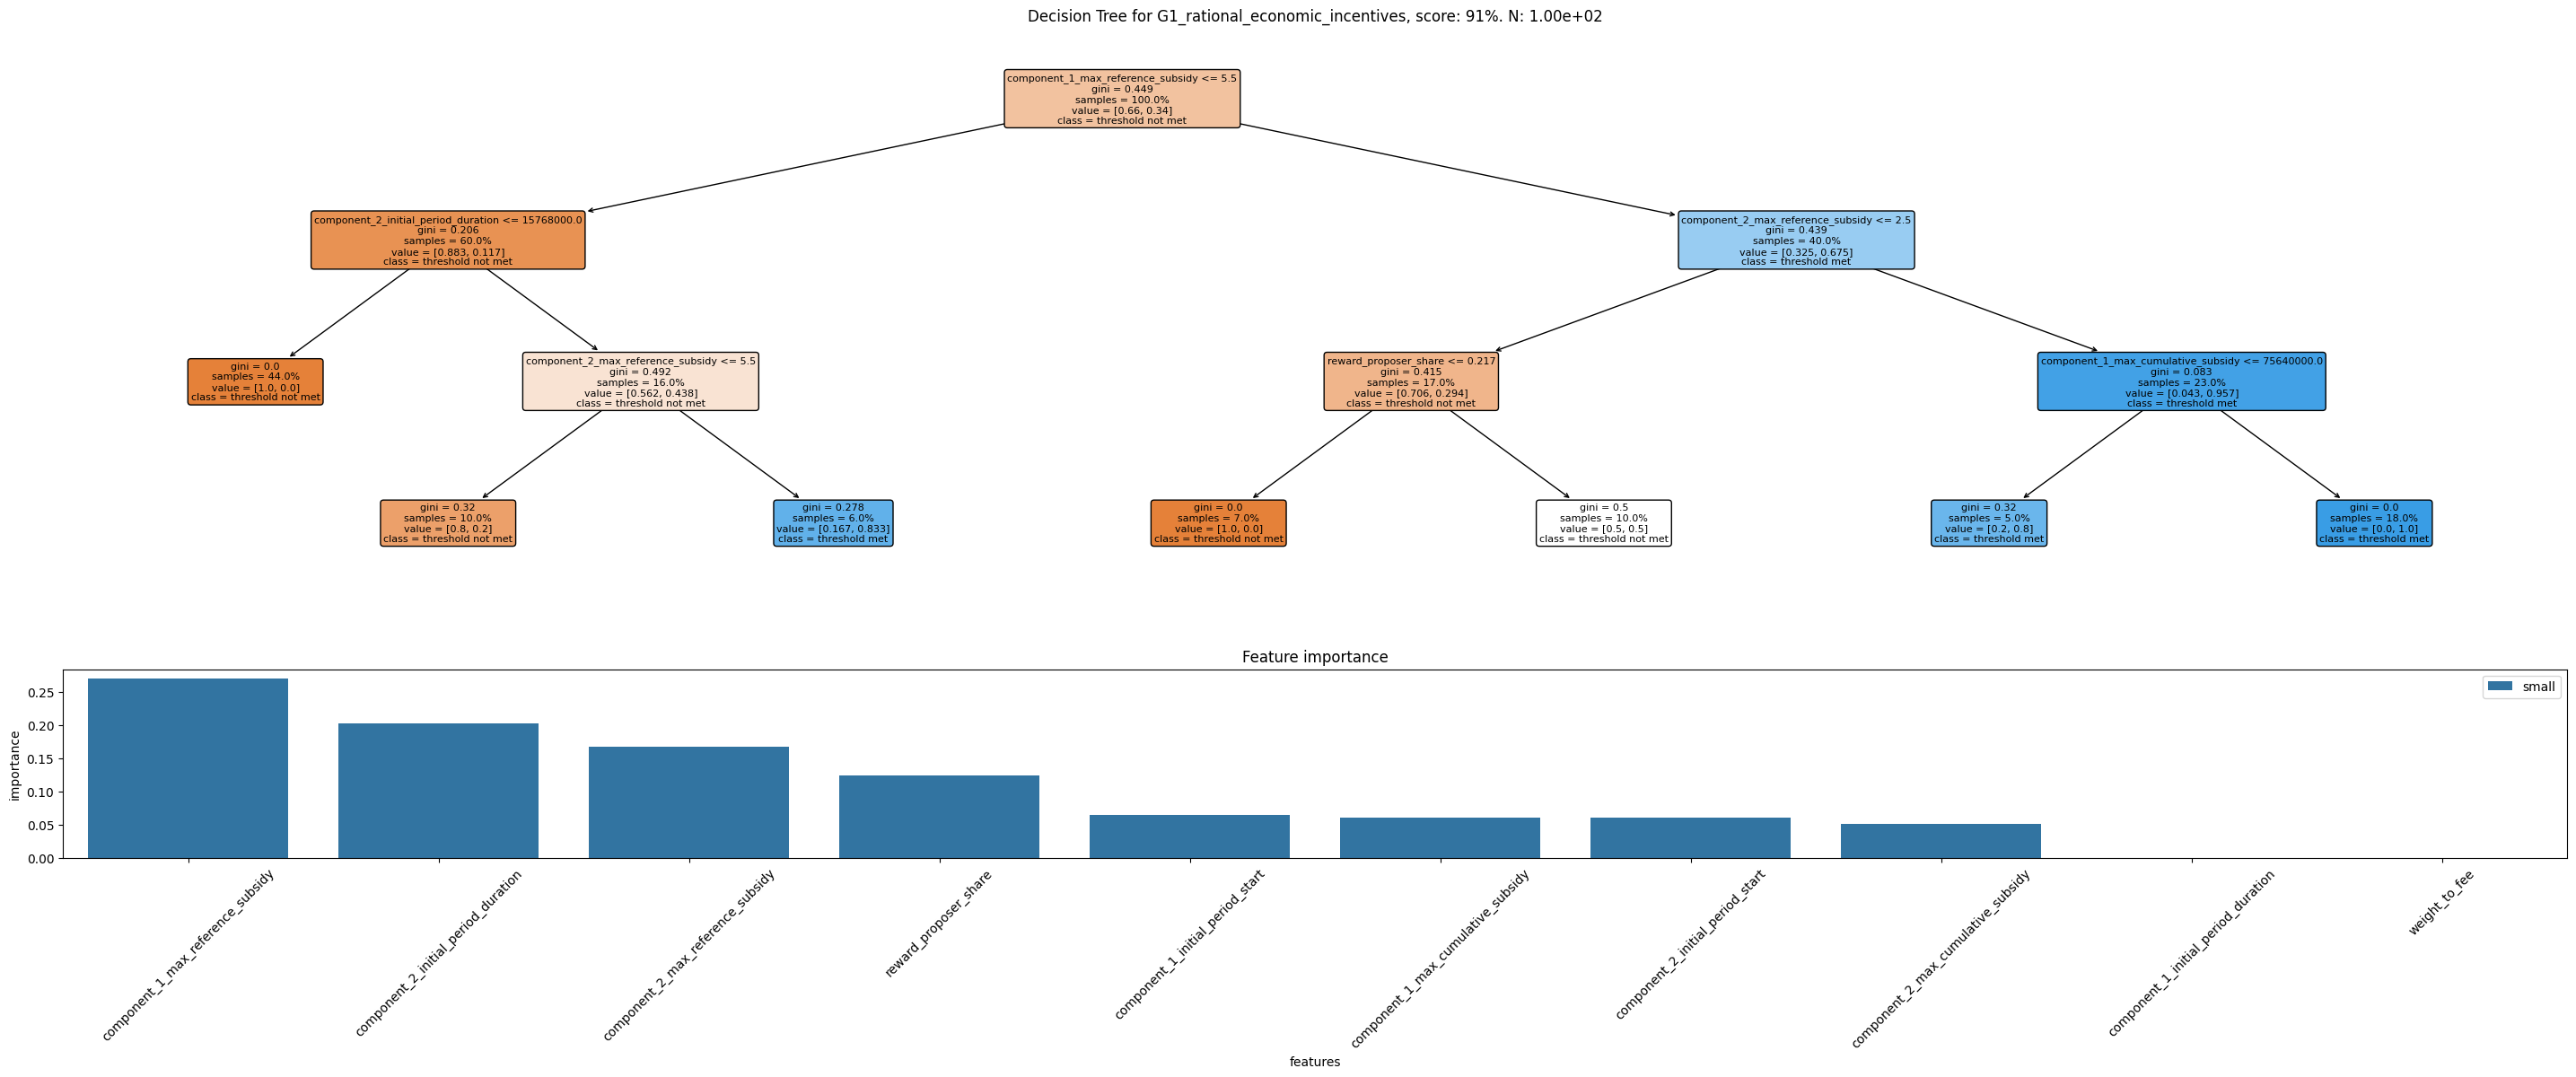

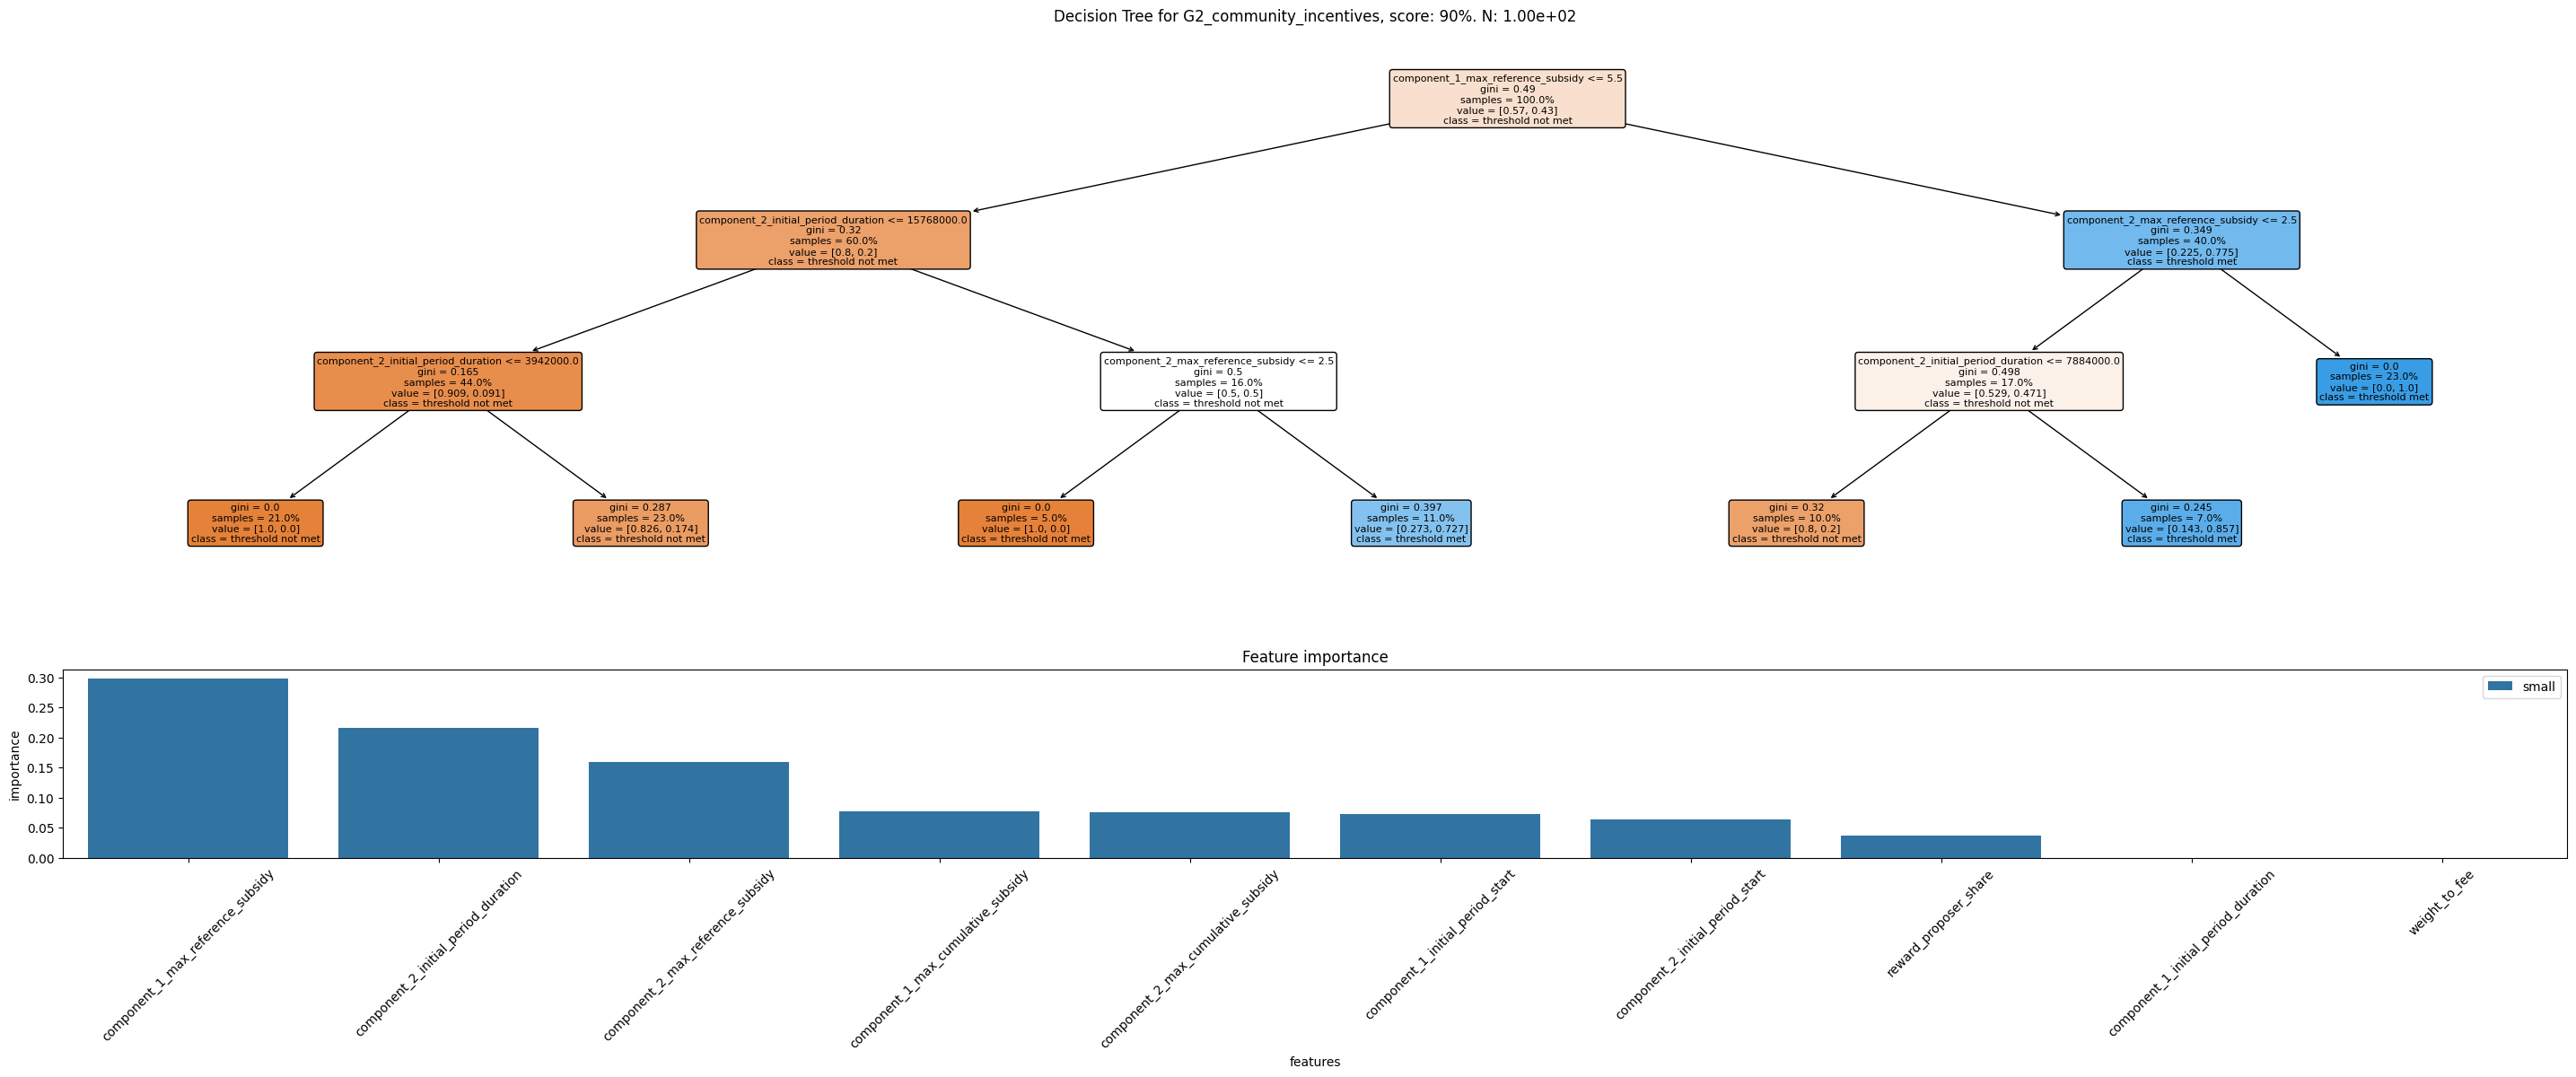

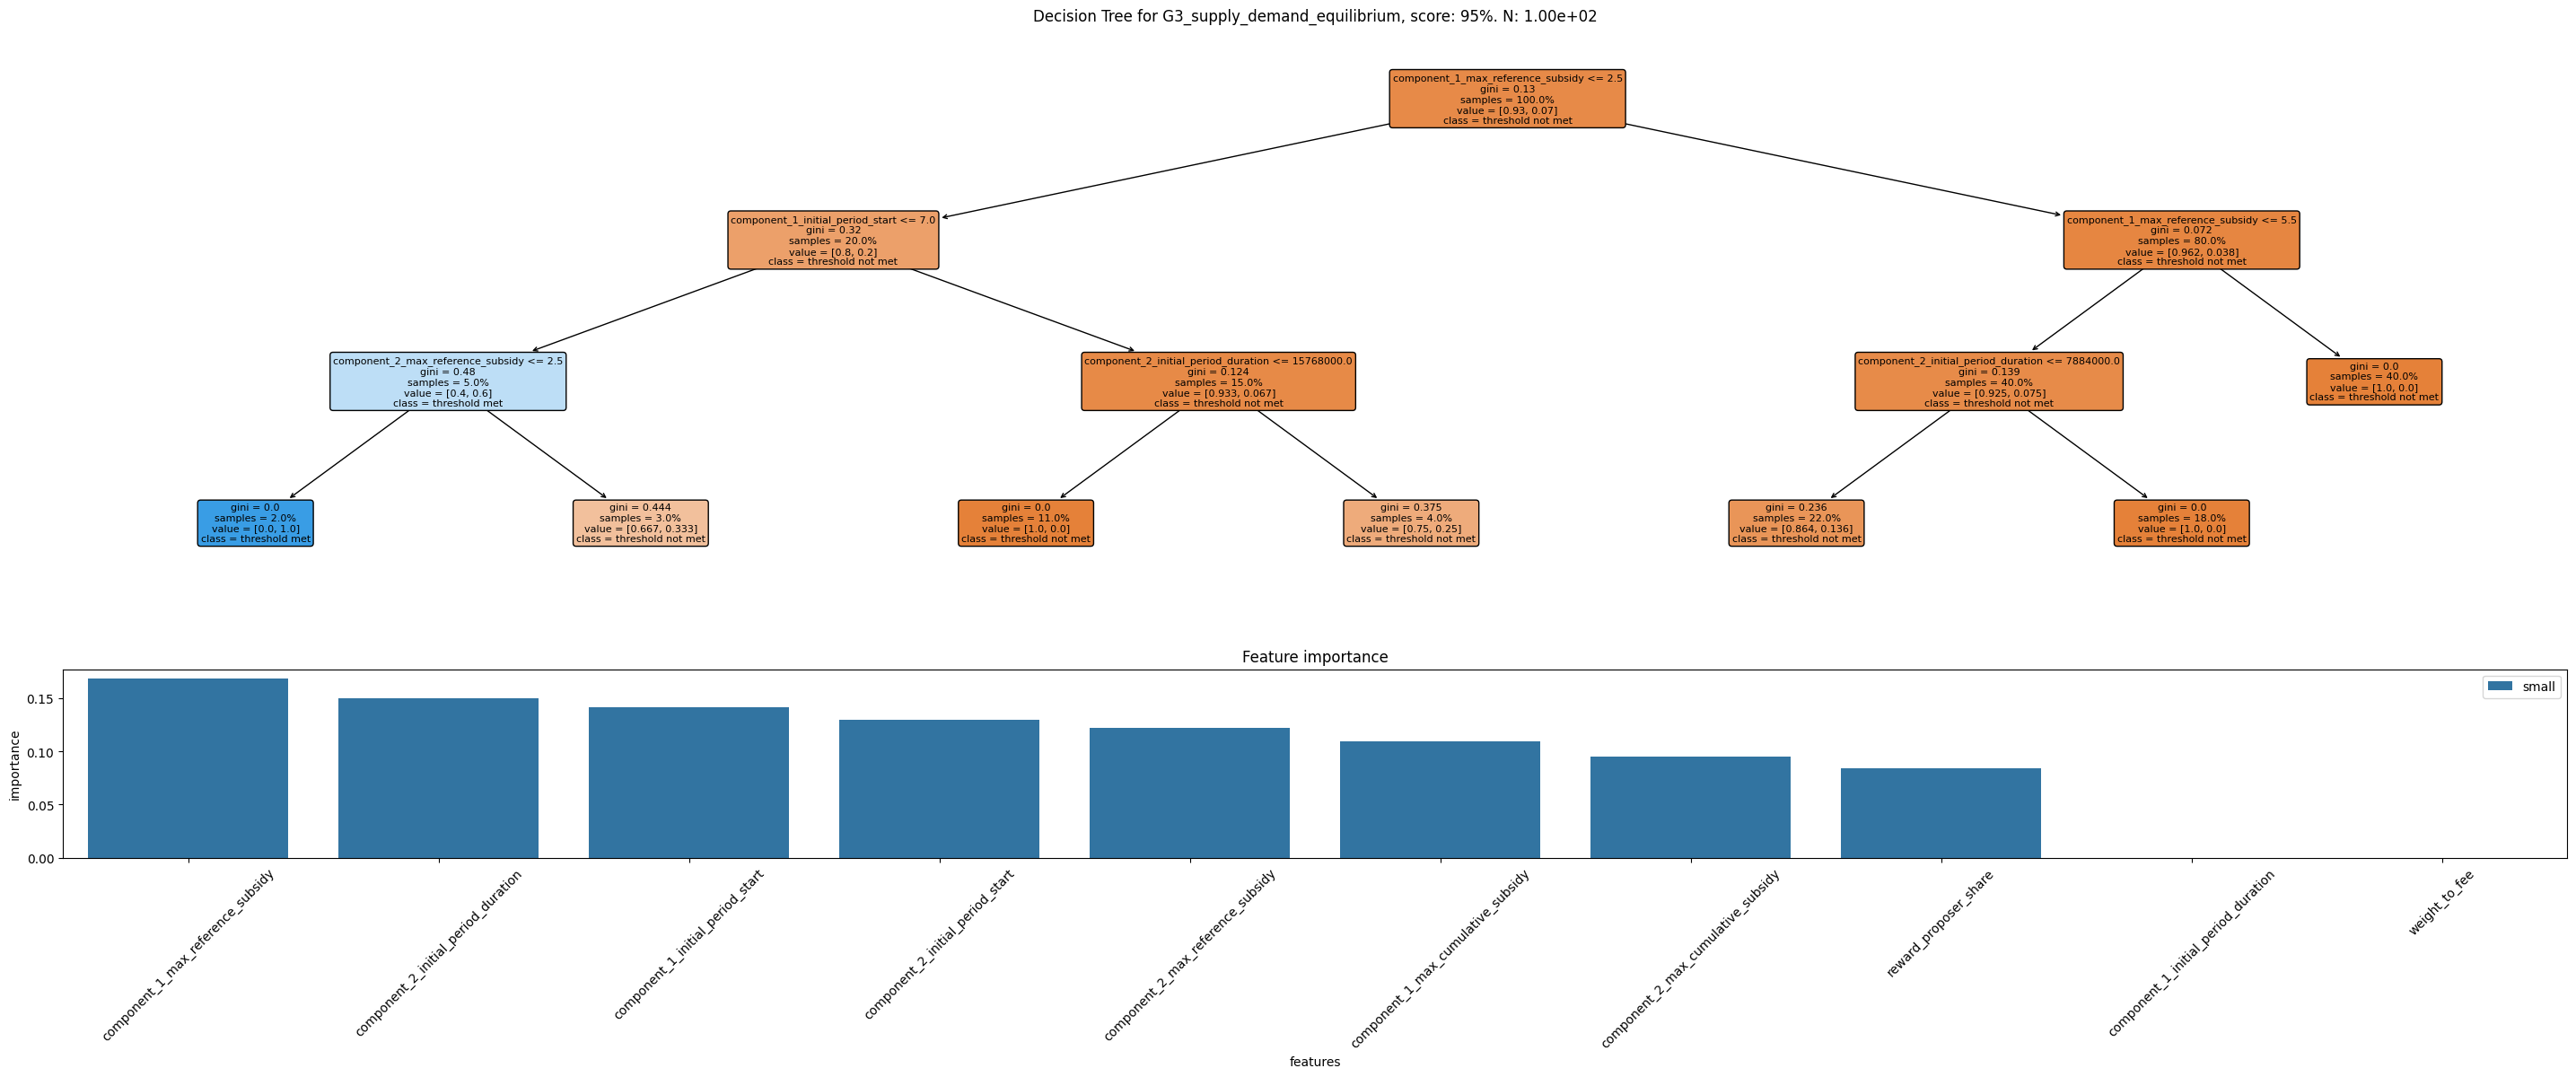

In [7]:
for goal, kpis in GOAL_KPI_GROUPS.items():
    goal_df = calculate_goal_score(agg_df, goal, goal)
    create_decision_tree_importances_plot(goal_df, goal, success_criteria='larger_than_median')


### Parameter Effect into KPIs

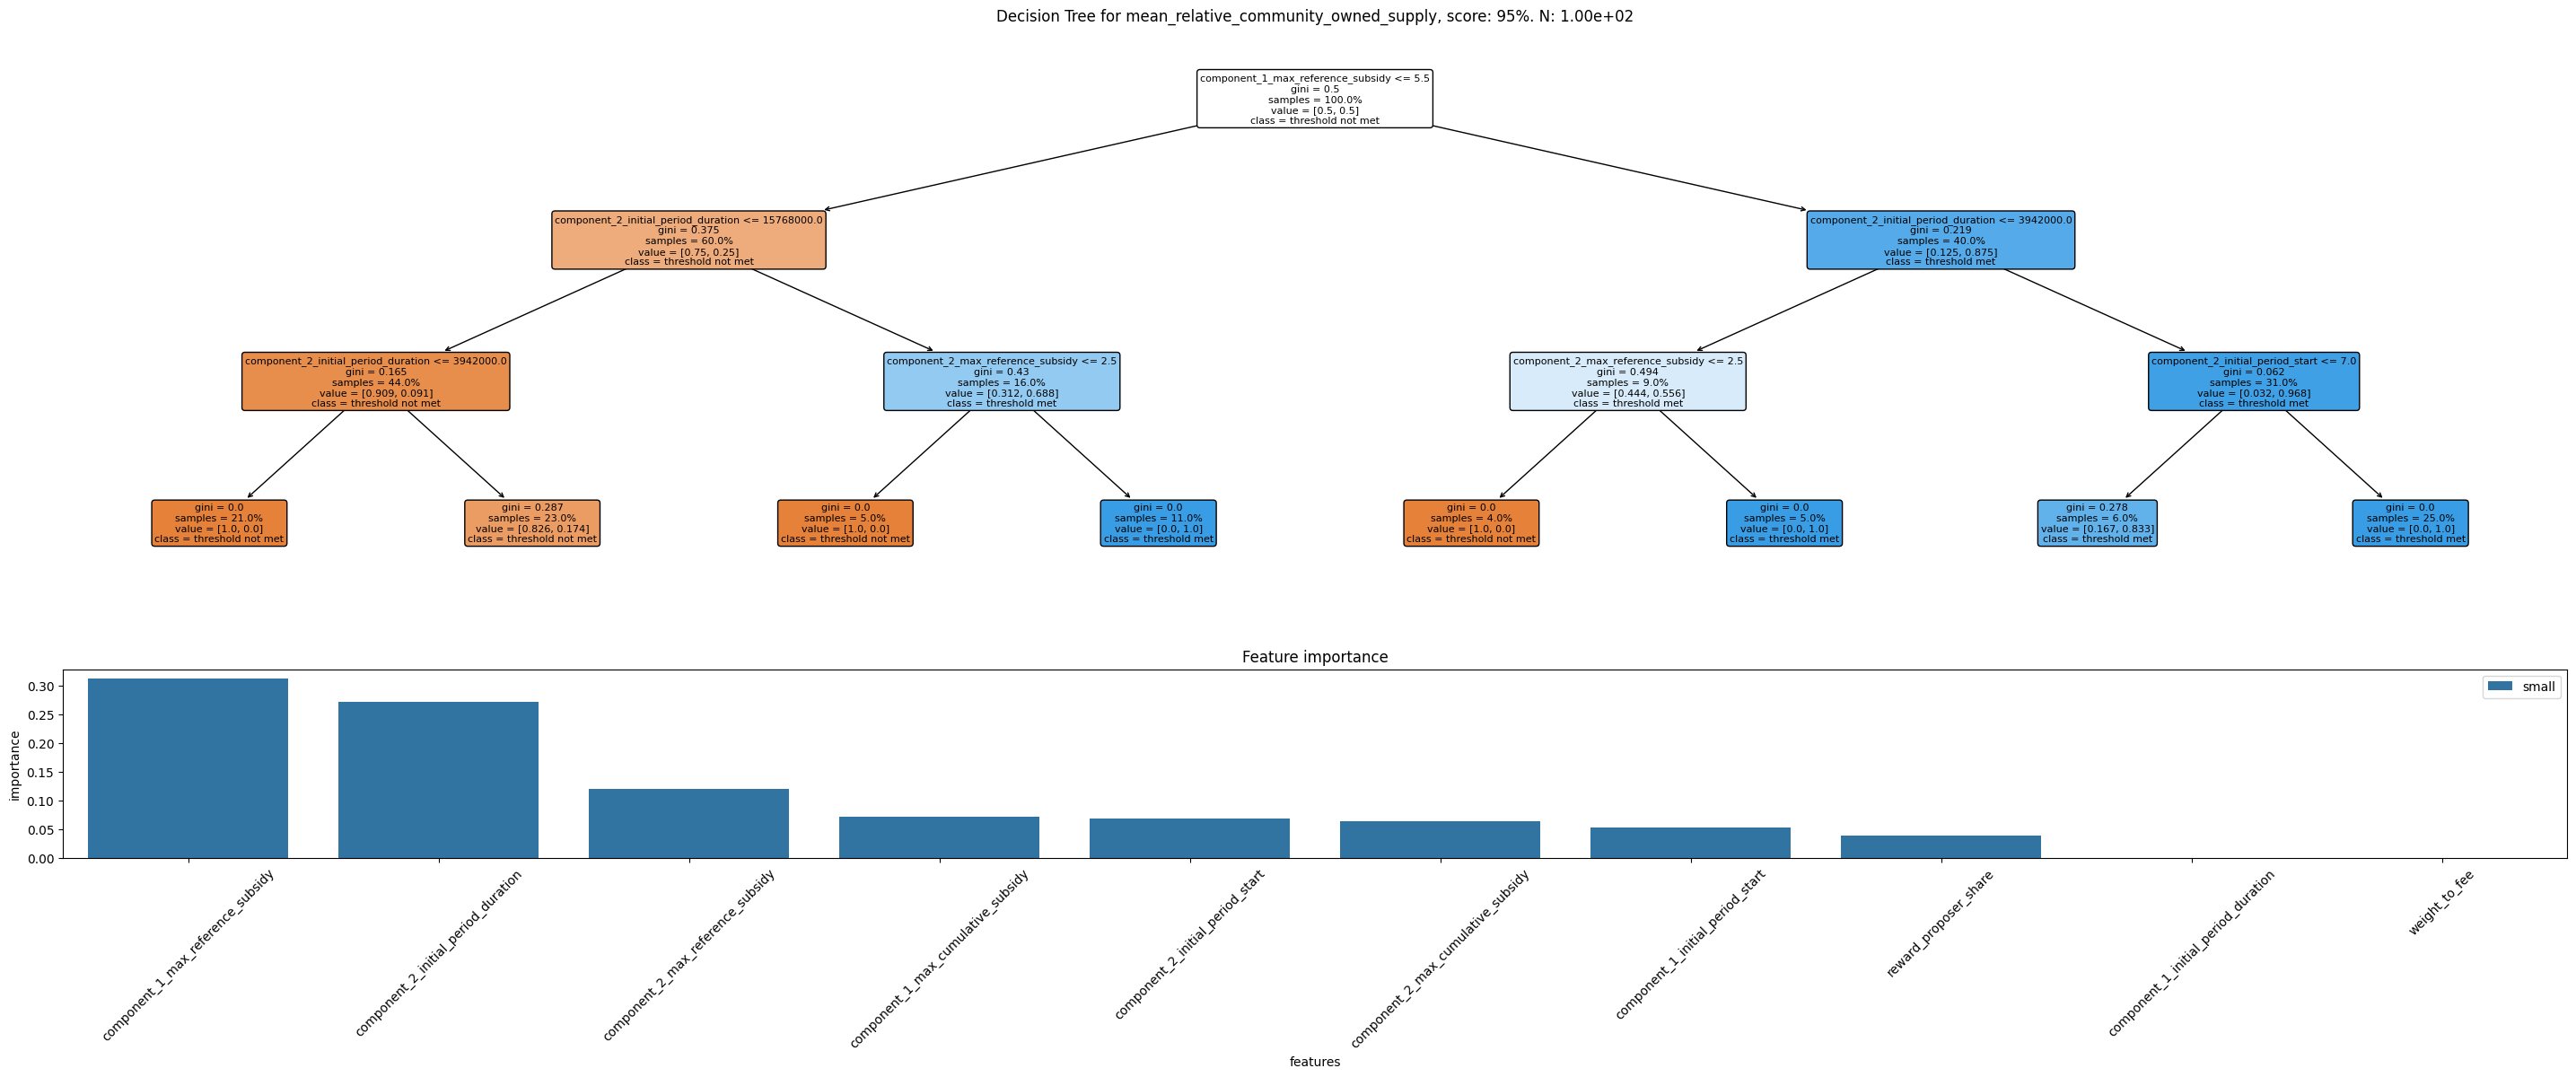

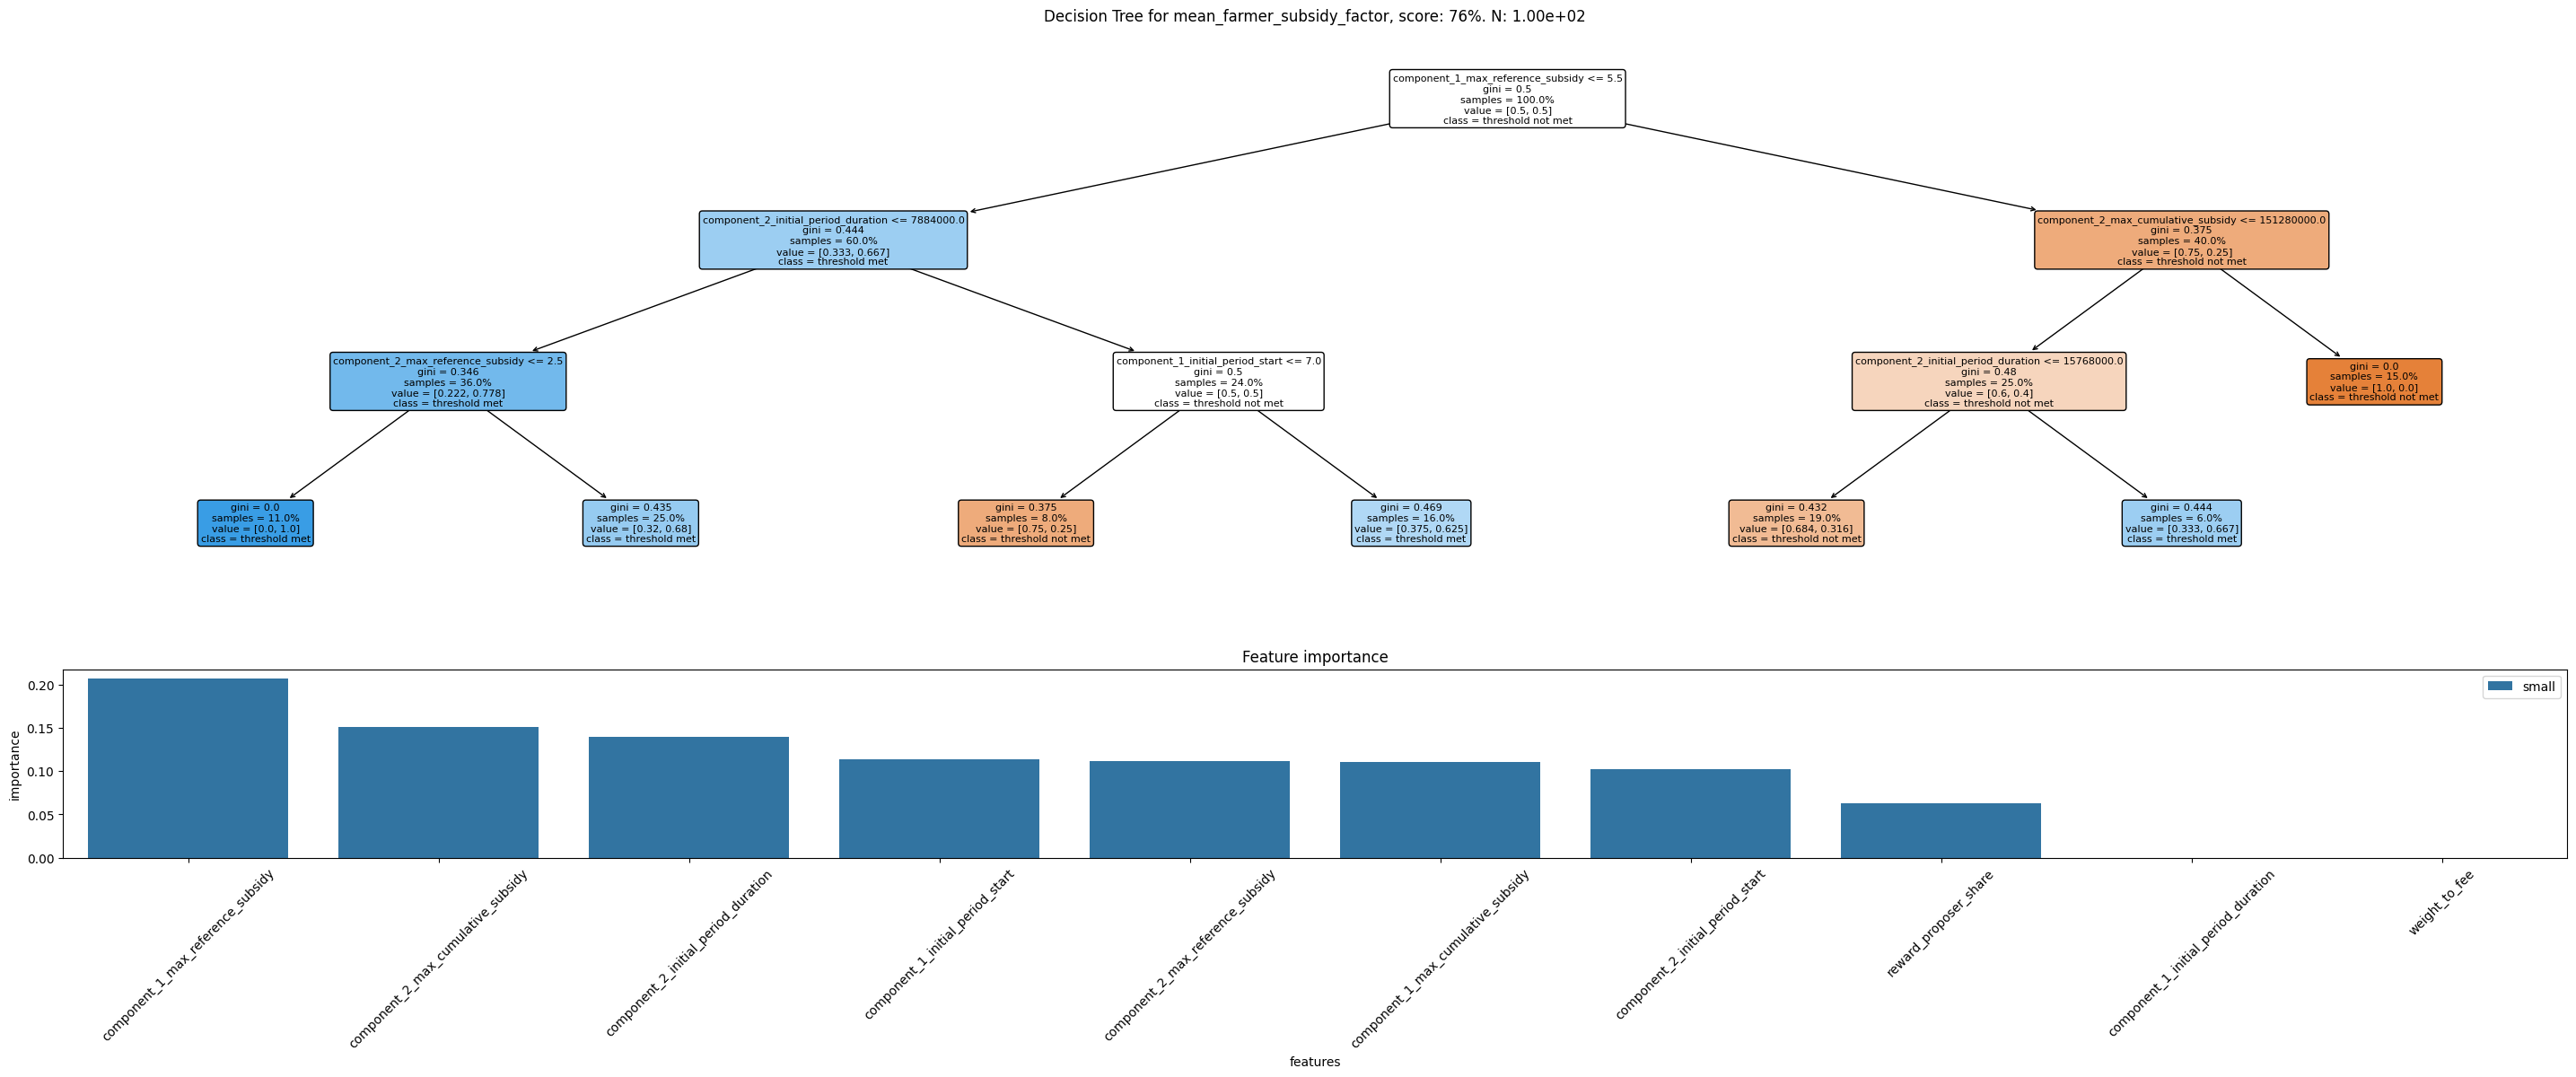

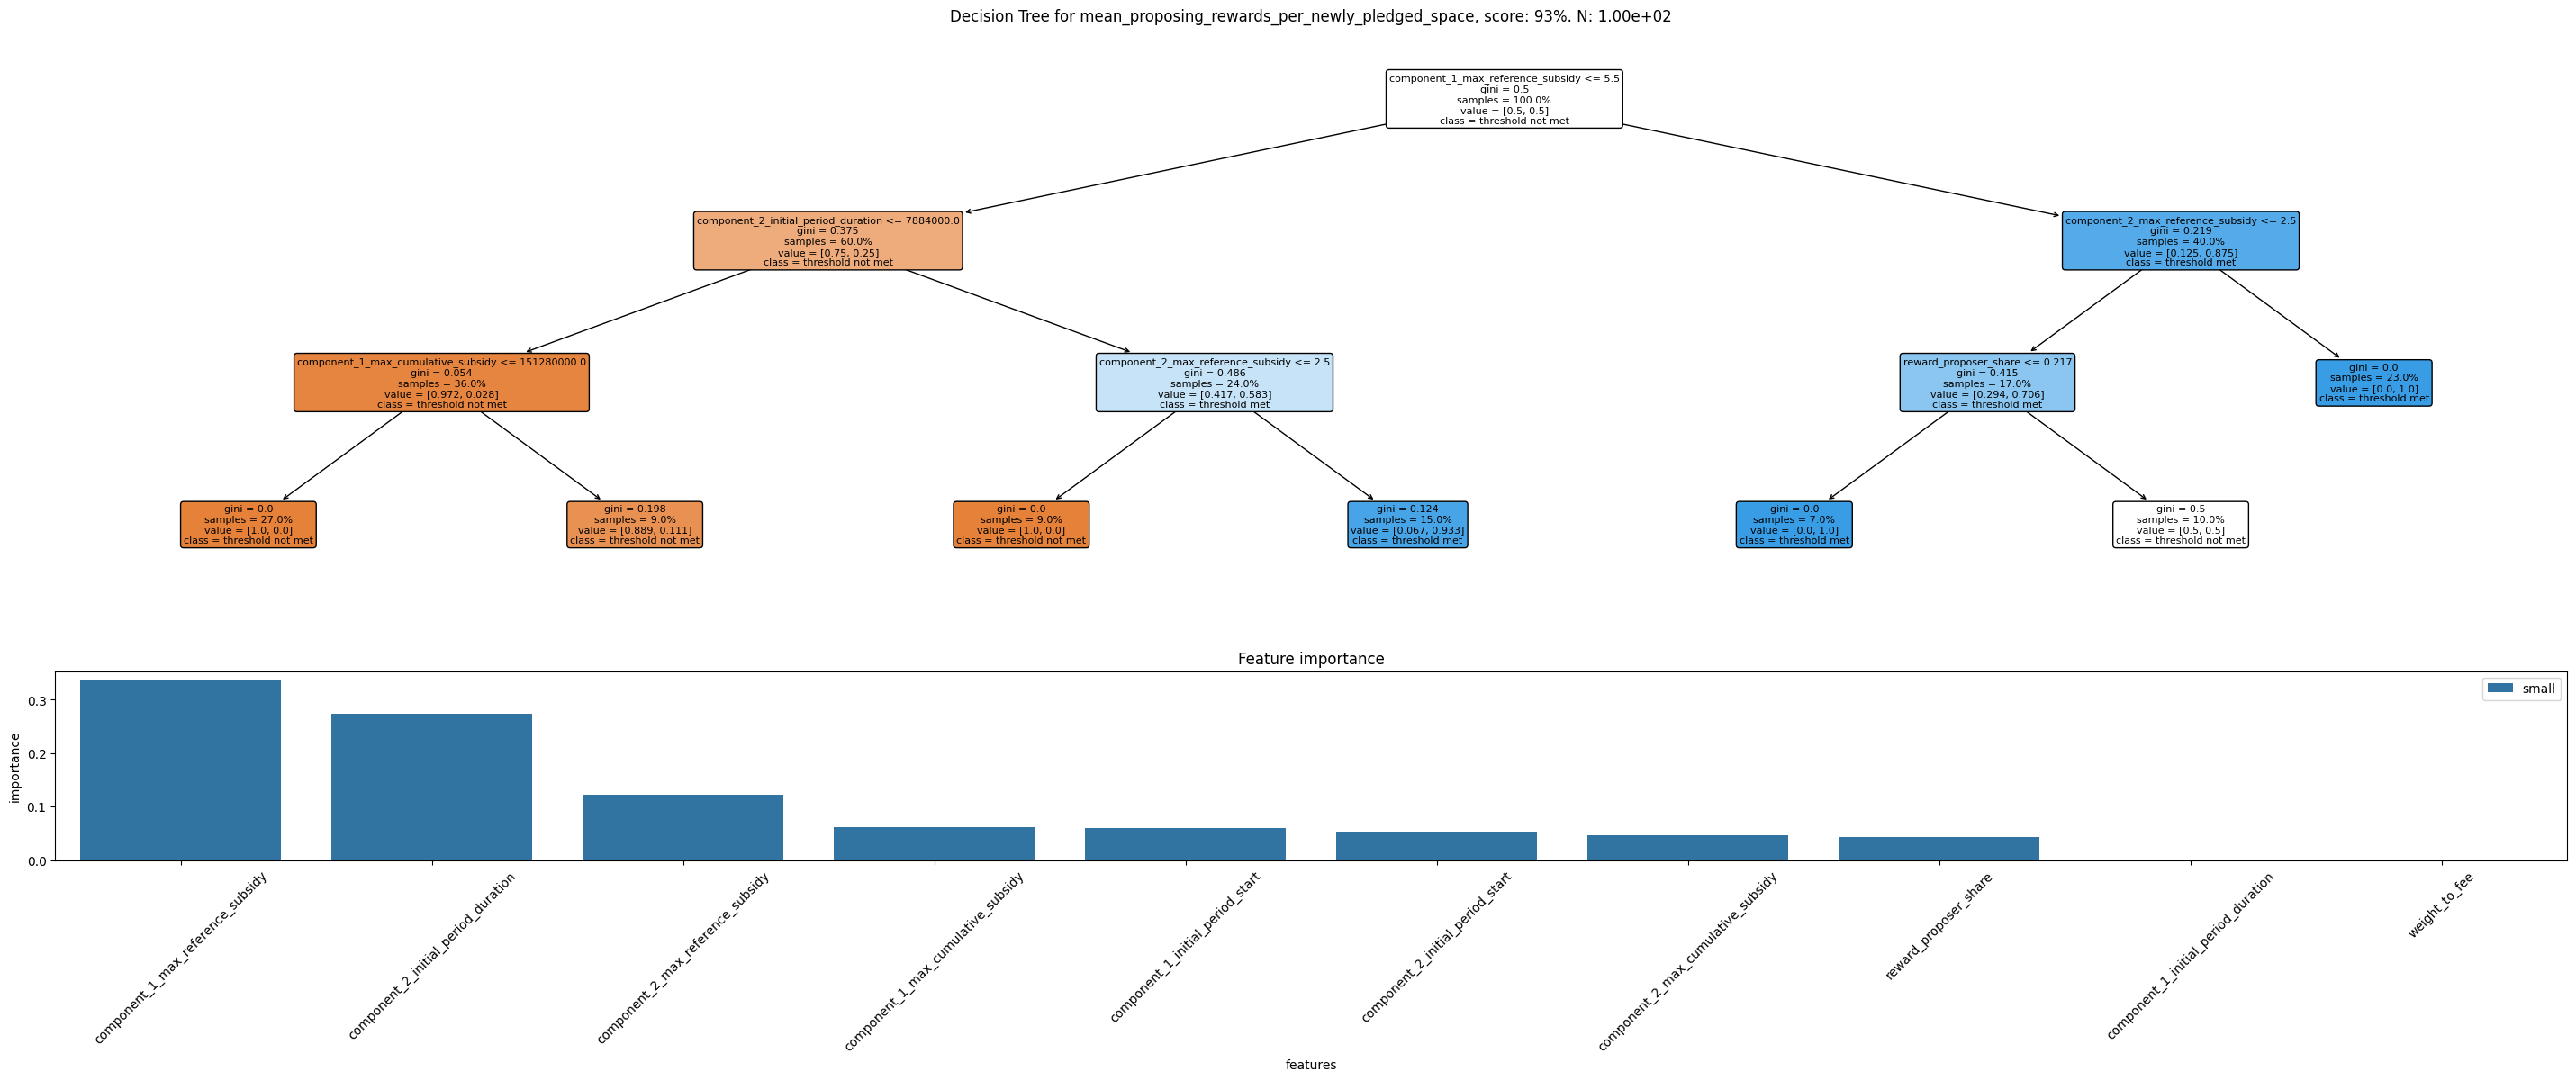

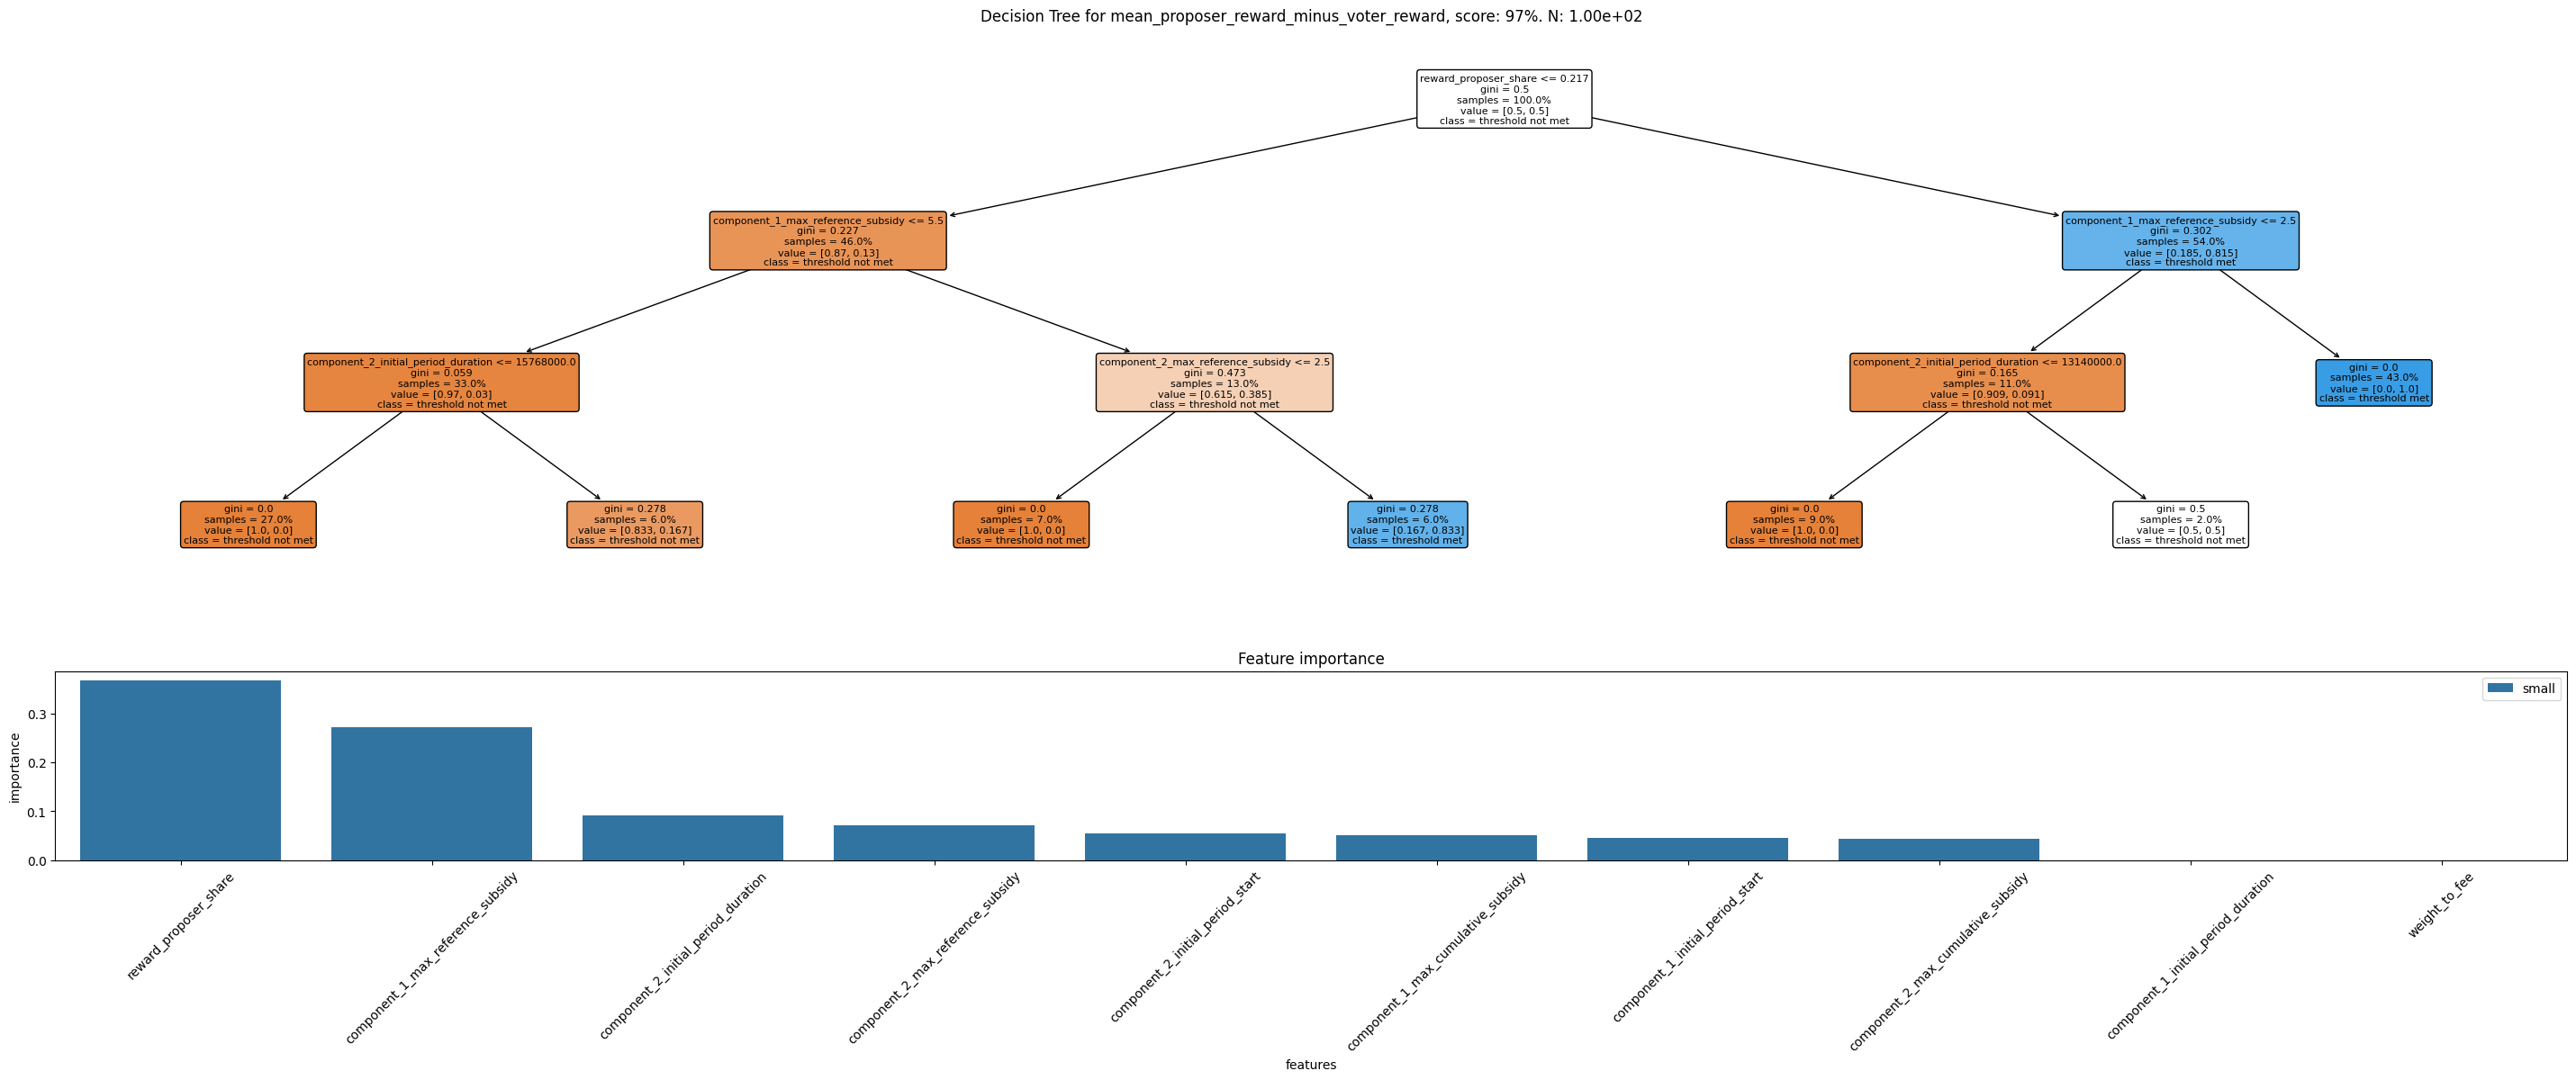

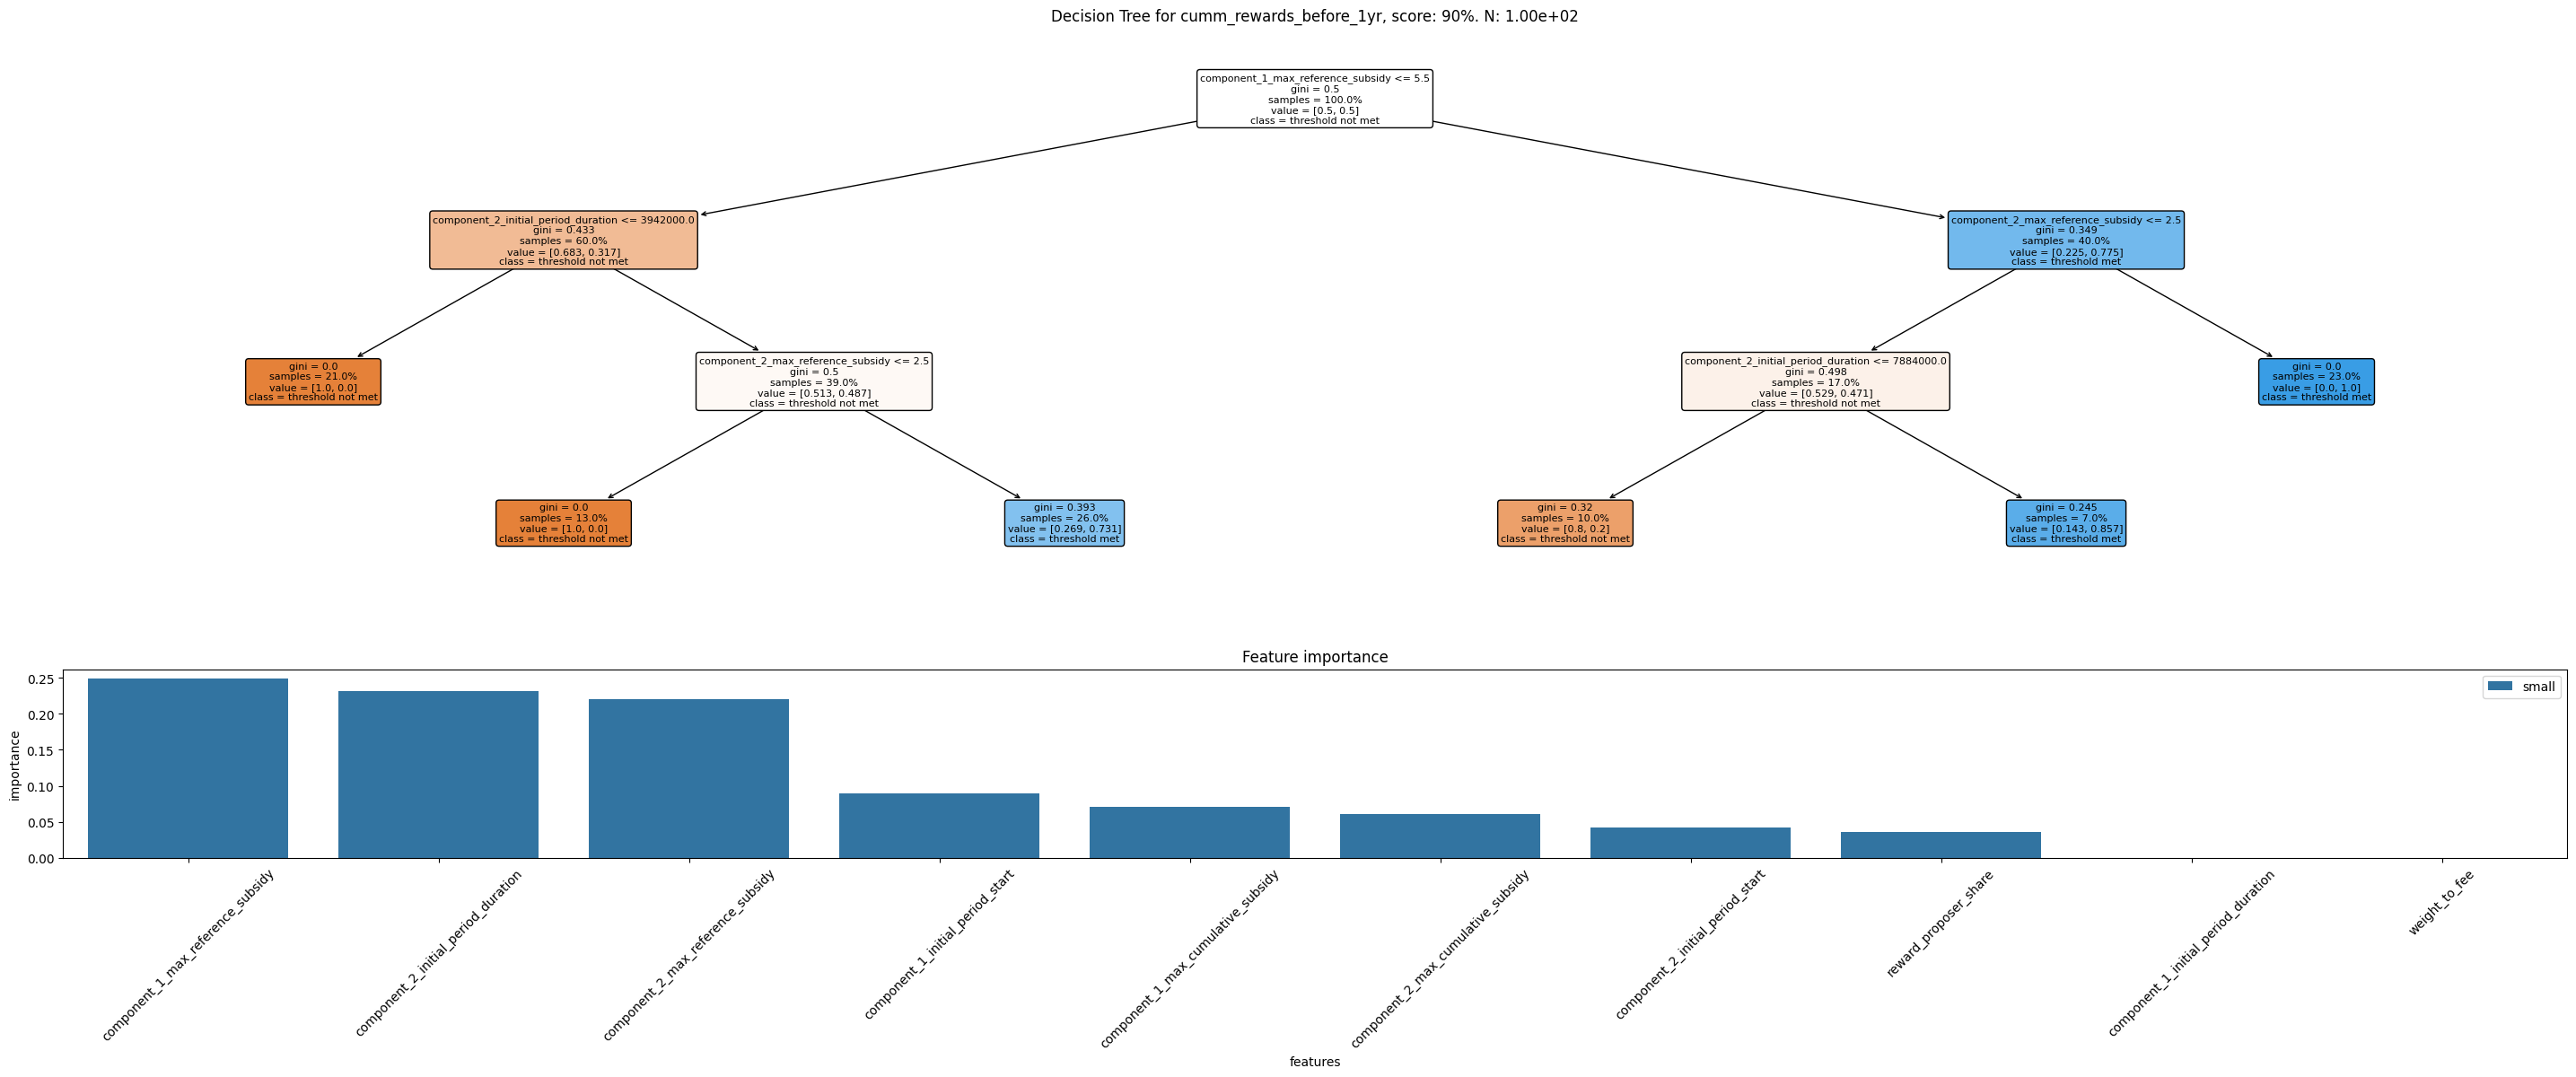

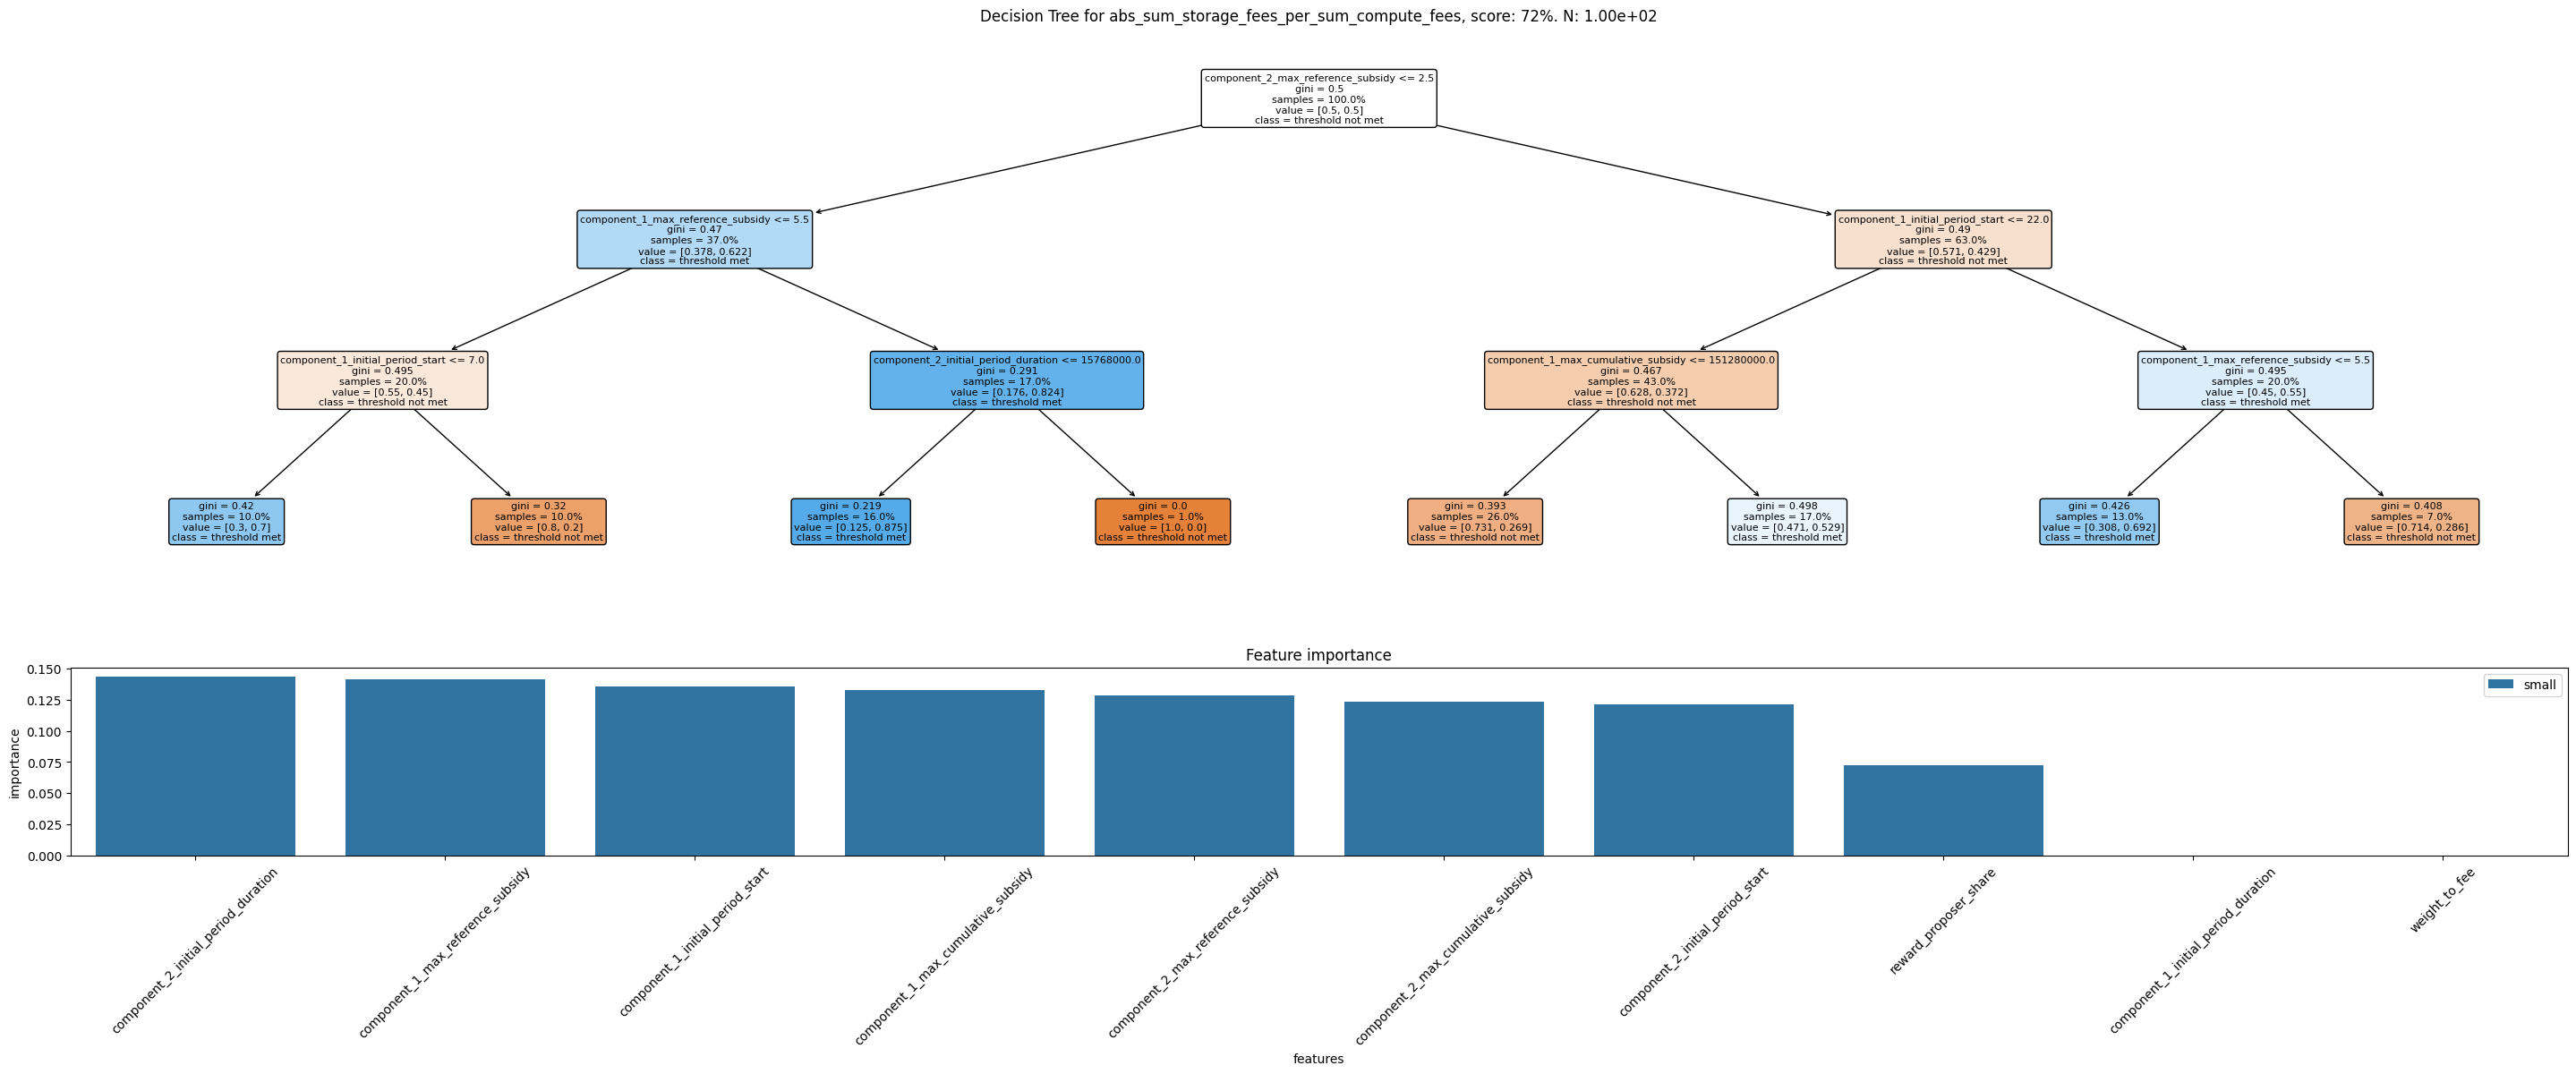

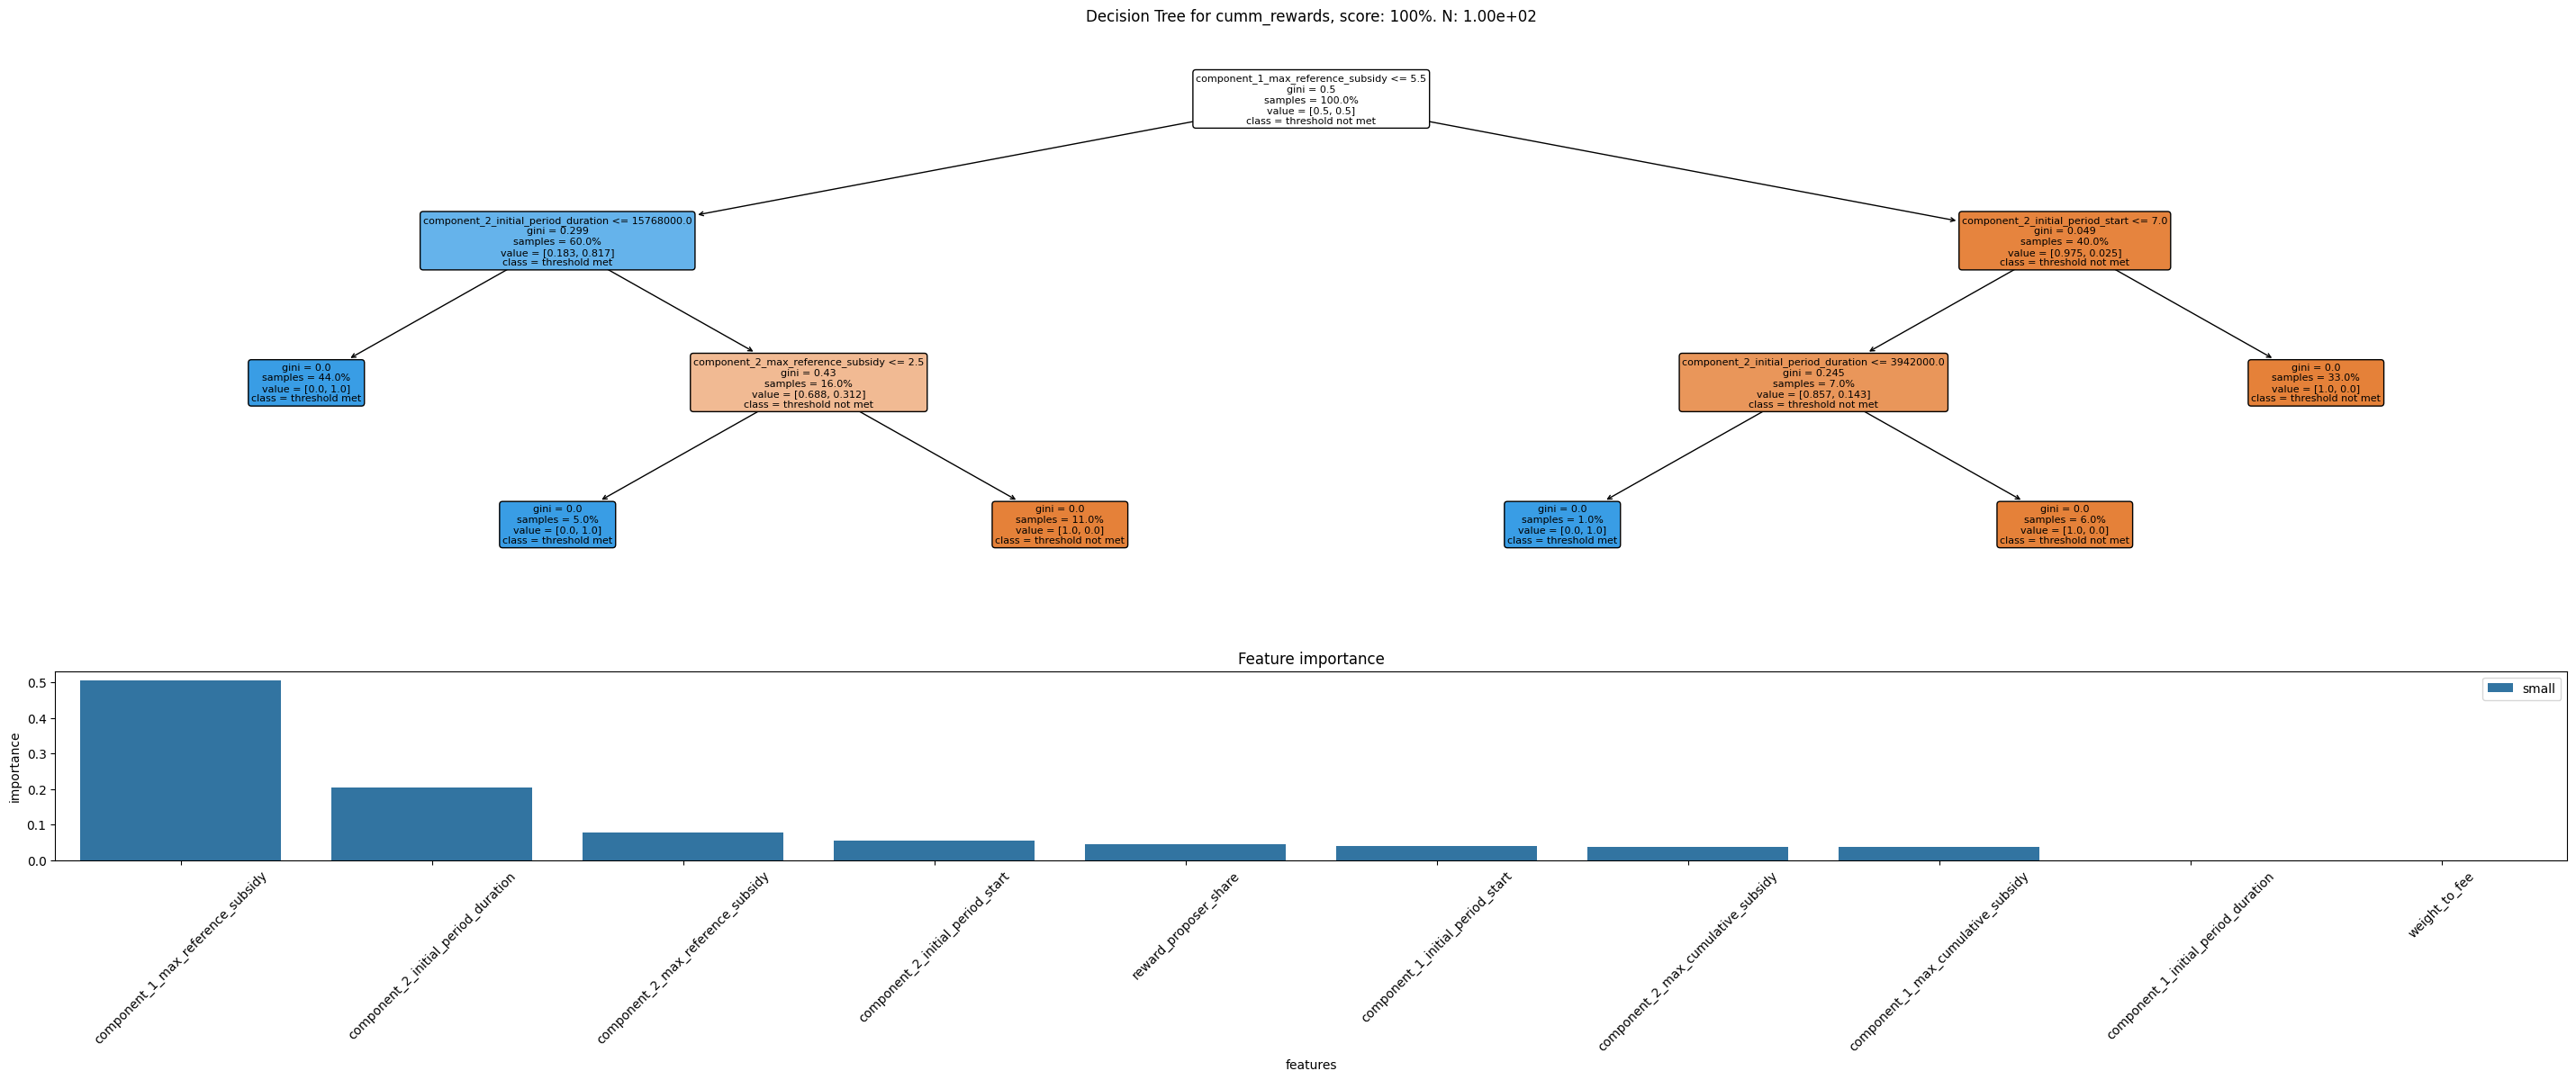

In [8]:
for col_name, (kpi_f, kpi_t) in KPI_functions.items():
    create_decision_tree_importances_plot(agg_df,
                                        col_name =col_name,
                                        success_criteria=kpi_t)
    plt.show()

### Auxiliary Visualizations

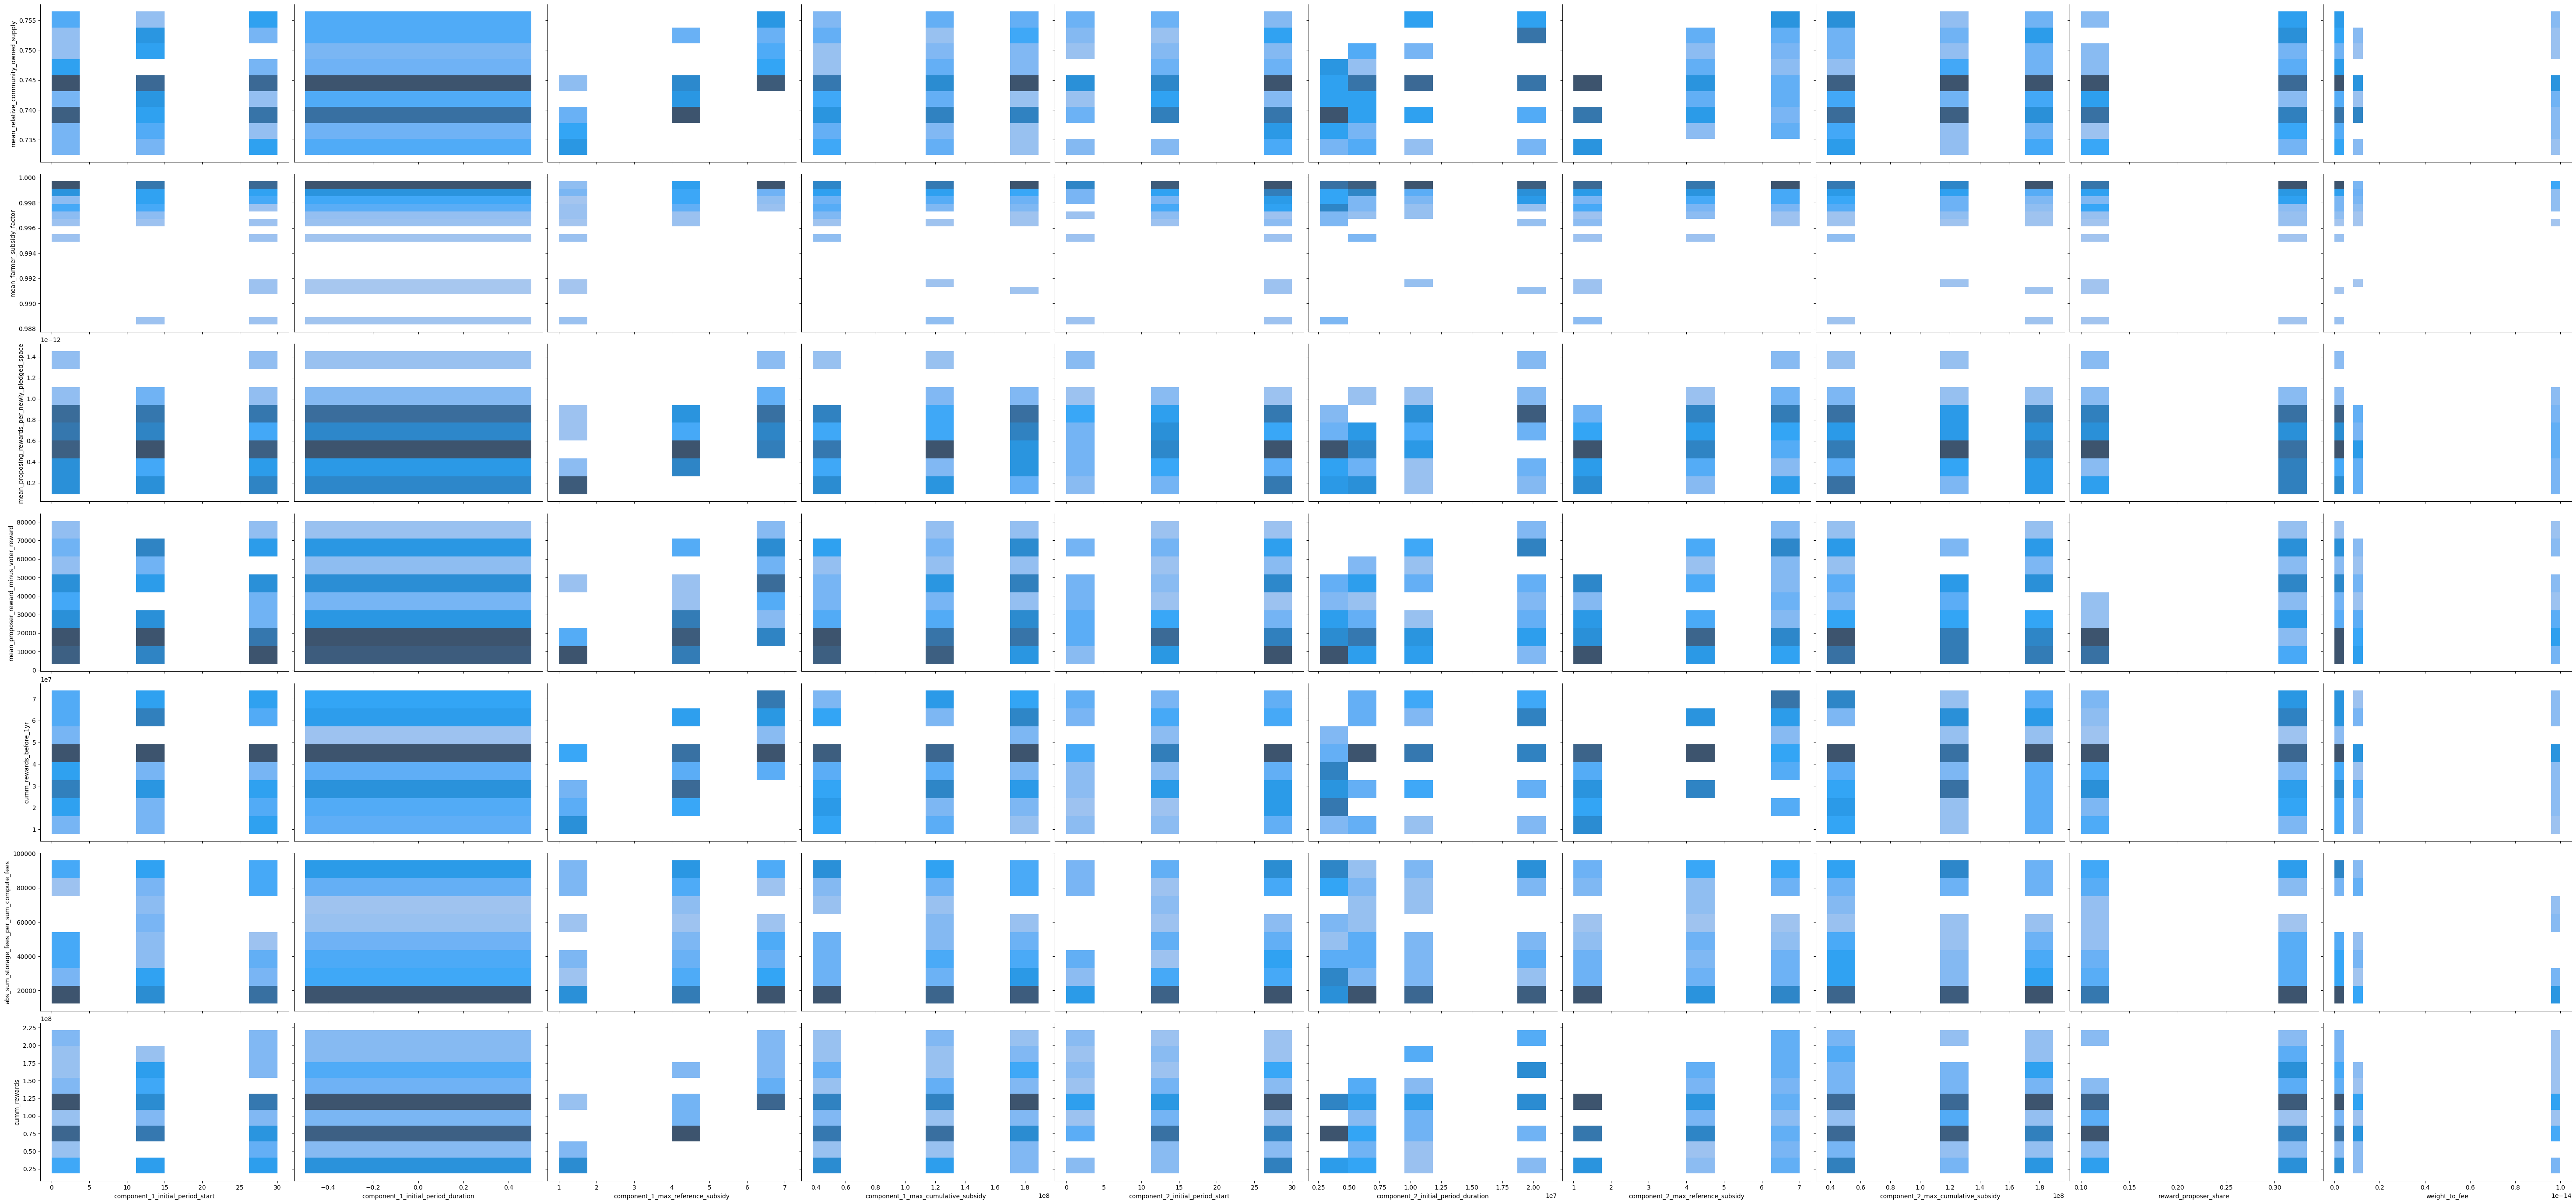

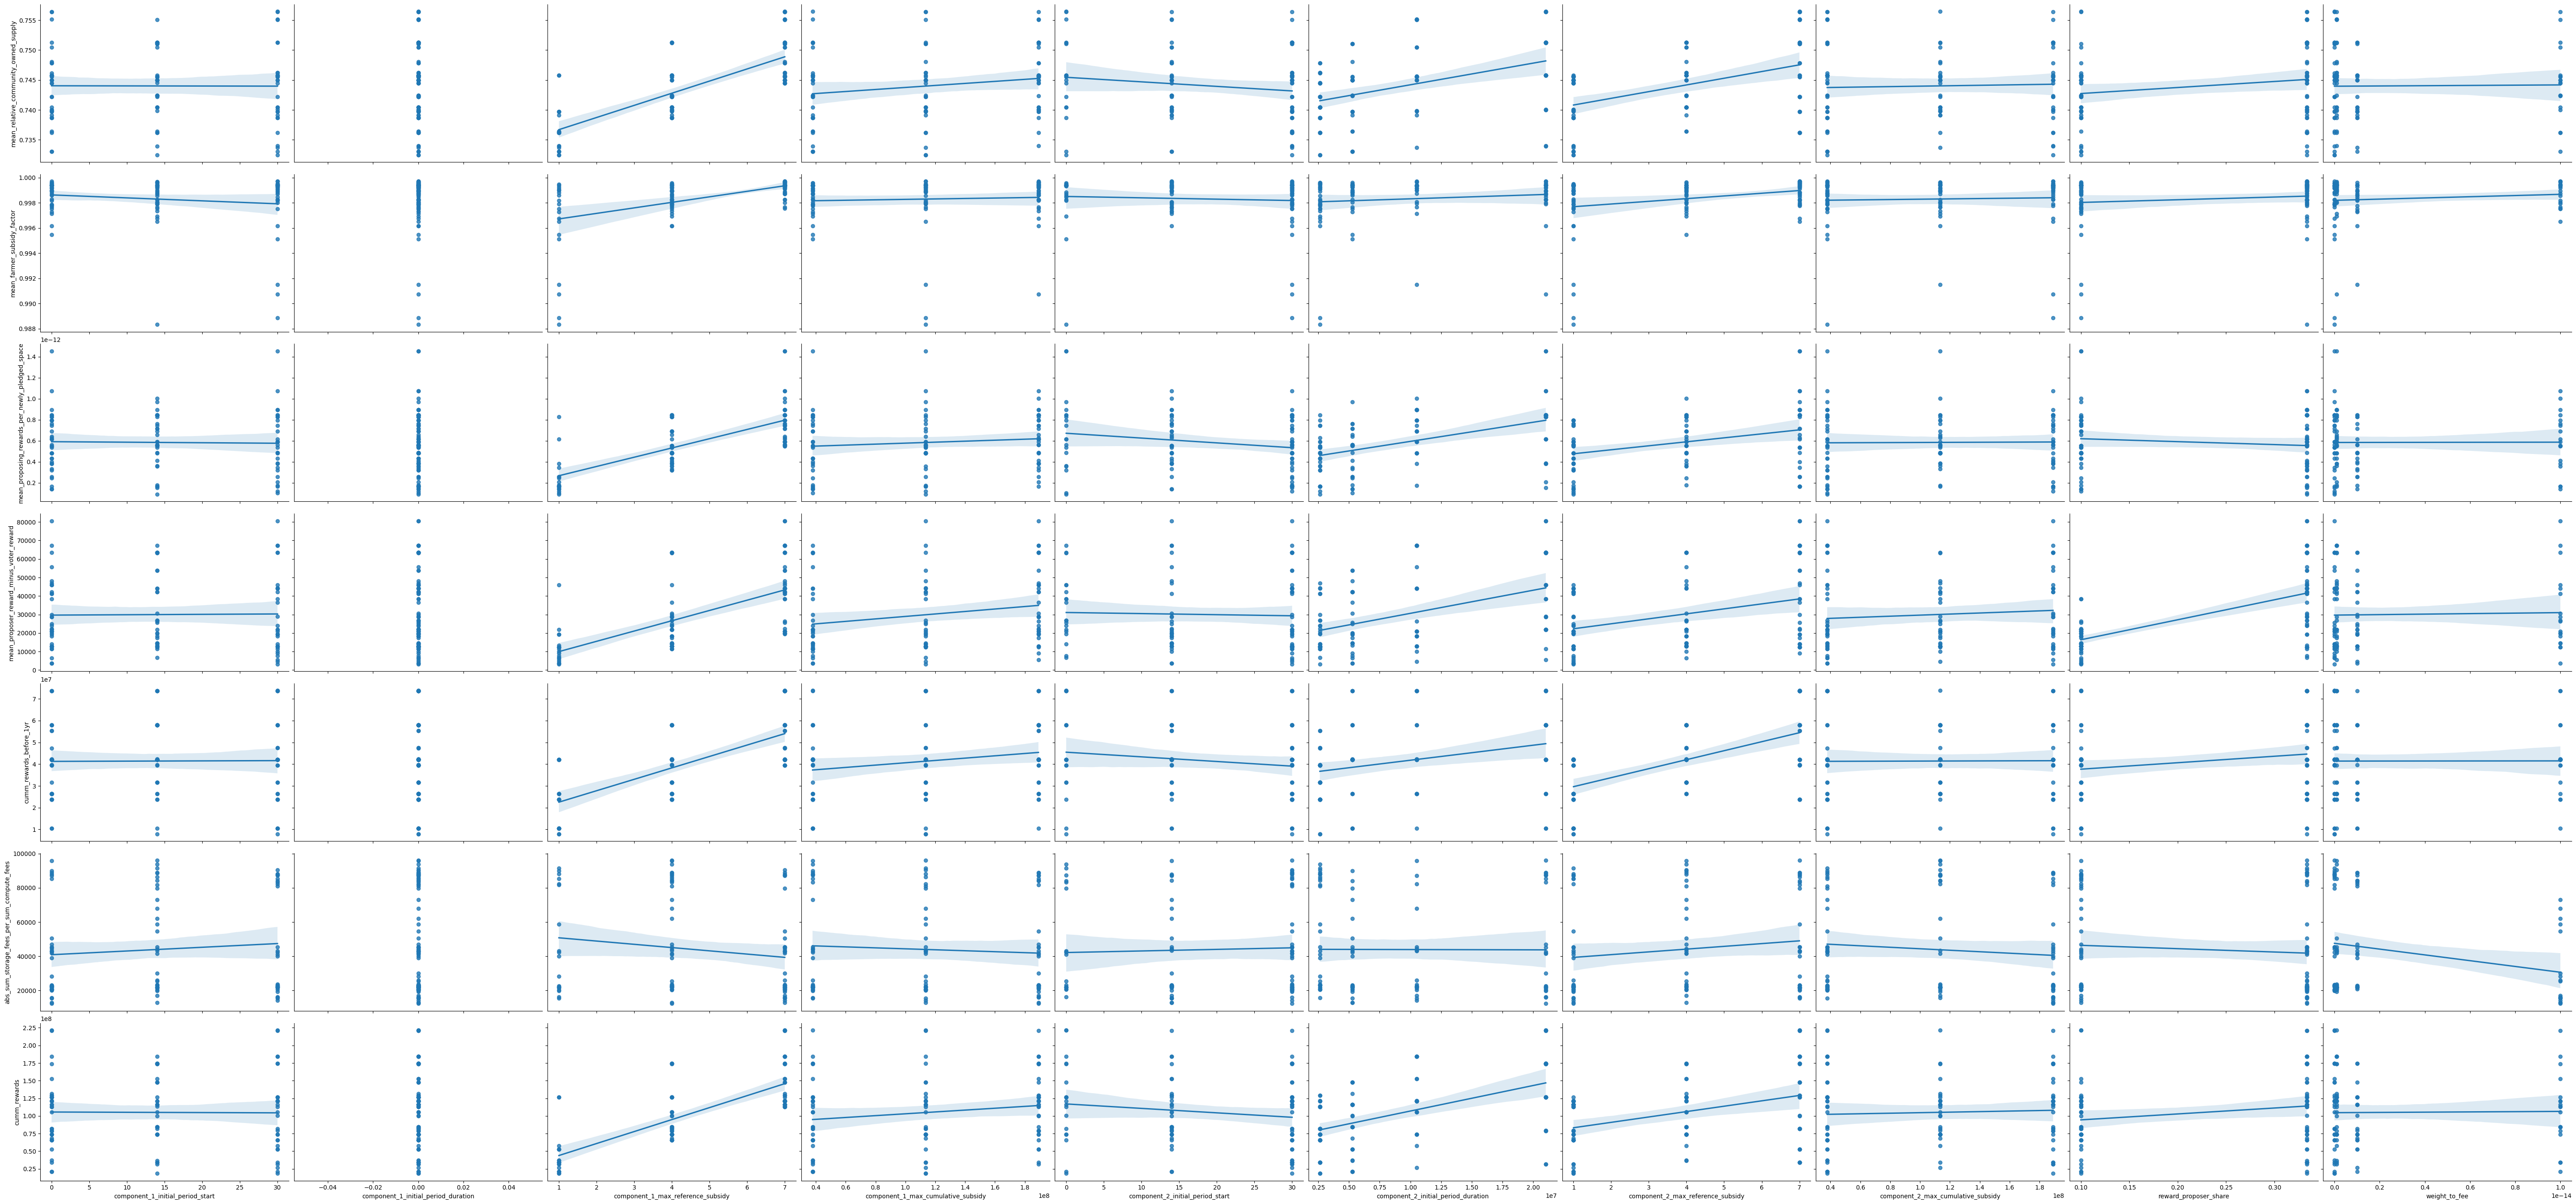

In [9]:
import seaborn as sns

N_params = len(GOVERNANCE_SURFACE_PARAMS)
N_kpis = len(KPI_functions)

N_rows = N_kpis
N_cols = N_params
HEIGHT = 4.0
ASPECT = 1.5

sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='hist')


sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='reg')


In [10]:
agg_df

simulation  subset  run  component_1_max_cumulative_subsidy  \
0            0       0    1                          37820000.0   
1            0       1    2                         113460000.0   
2            0       2    3                         113460000.0   
3            0       3    4                         189100000.0   
4            0       4    5                          37820000.0   
..         ...     ...  ...                                 ...   
95           0      95   16                         189100000.0   
96           0      96   17                         189100000.0   
97           0      97   18                         189100000.0   
98           0      98   19                         113460000.0   
99           0      99   20                          37820000.0   

    component_2_initial_period_duration  component_1_initial_period_duration  \
0                             2628000.0                                    0   
1                             5256000.0                                    0   
2                             2628000.0                                    0   
3                            21024000.0                                    0   
4                            21024000.0                                    0   
..                                  ...                                  ...   
95                            2628000.0                                    0   
96                           10512000.0                                    0   
97                           21024000.0                                    0   
98                            2628000.0                                    0   
99                           21024000.0                                    0   

    component_1_initial_period_start  component_2_max_reference_subsidy  \
0                                 30                                  1   
1                                 14                                  4   
2                                 14                                  7   
3                                 30                                  1   
4                                 30                                  4   
..                               ...                                ...   
95                                30                                  1   
96                                14                                  7   
97                                14                                  4   
98                                30                                  4   
99                                30                                  7   

    reward_proposer_share  weight_to_fee  component_1_max_reference_subsidy  \
0                0.100000   1.000000e-16                                  4   
1                0.100000   1.000000e-14                                  4   
2                0.100000   1.000000e-18                                  4   
3                0.333333   1.000000e-15                                  4   
4                0.333333   1.000000e-18                                  7   
..                    ...            ...                                ...   
95               0.333333   1.000000e-15                                  4   
96               0.333333   1.000000e-16                                  7   
97               0.333333   1.000000e-14                                  7   
98               0.100000   1.000000e-16                                  4   
99               0.100000   1.000000e-18                                  7   

    component_2_max_cumulative_subsidy  component_2_initial_period_start  \
0                           37820000.0                                14   
1                          113460000.0                                14   
2                           37820000.0                                30   
3                          113460000.0                                14   
4       

In [11]:
for k in KPI_functions.keys():
    c = agg_df[k].value_counts()
    if len(c) <= 10:
        print(c)

In [12]:
d = agg_df[KPI_functions.keys()].describe().T
d['mean']

mean_relative_community_owned_supply              7.440008e-01
mean_farmer_subsidy_factor                        9.982992e-01
mean_proposing_rewards_per_newly_pledged_space    5.843323e-13
mean_proposer_reward_minus_voter_reward           2.996714e+04
cumm_rewards_before_1yr                           4.140318e+07
abs_sum_storage_fees_per_sum_compute_fees         4.392441e+04
cumm_rewards                                      1.049798e+08
Name: mean, dtype: float64

In [13]:
d['std'] / d['mean']

mean_relative_community_owned_supply              0.008123
mean_farmer_subsidy_factor                        0.002003
mean_proposing_rewards_per_newly_pledged_space    0.472585
mean_proposer_reward_minus_voter_reward           0.663306
cumm_rewards_before_1yr                           0.414561
abs_sum_storage_fees_per_sum_compute_fees         0.636630
cumm_rewards                                      0.481128
dtype: float64